In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
import re
import shutil
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, jaccard_score, f1_score, homogeneity_completeness_v_measure, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, pairwise_distances
import numpy as np
from scipy.optimize import linear_sum_assignment
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!wget -O Stsbenchmark.tar.gz http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
shutil.unpack_archive('./Stsbenchmark.tar.gz', extract_dir='./', format='gztar')

--2023-11-04 05:26:10--  http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz
Resolving ixa2.si.ehu.es (ixa2.si.ehu.es)... 158.227.106.100
Connecting to ixa2.si.ehu.es (ixa2.si.ehu.es)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://ixa2.si.ehu.eus/stswiki/images/4/48/Stsbenchmark.tar.gz [following]
--2023-11-04 05:26:11--  http://ixa2.si.ehu.eus/stswiki/images/4/48/Stsbenchmark.tar.gz
Resolving ixa2.si.ehu.eus (ixa2.si.ehu.eus)... 158.227.106.100
Connecting to ixa2.si.ehu.eus (ixa2.si.ehu.eus)|158.227.106.100|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409630 (400K) [application/x-gzip]
Saving to: ‘Stsbenchmark.tar.gz’

Stsbenchmark.tar.gz 100%[===================>] 400.03K   473KB/s    in 0.8s    

2023-11-04 05:26:12 (473 KB/s) - ‘Stsbenchmark.tar.gz’ saved [409630/409630]



In [3]:
def getSTSBenchmarkSents(filename='sts-train.csv', root='stsbenchmark/', encoding='utf-8'):
  f = open(root+filename, 'r', encoding=encoding)
  s1, s2, target = [], [], []
  for line in f:
    example = re.split(r'\t+', line)
    if len(example) > 7:
      example = example[:-2]
    s2.append(example[-1])
    s1.append(example[-2])
    target.append(float(example[-3]))
  print("{} samples: {}".format(filename, len(target)))
  return s1, s2, target

In [4]:
s1_test,s2_test,target_test= getSTSBenchmarkSents(filename='sts-test.csv')

sts-test.csv samples: 1379


In [5]:
BERT_PATH = "bert-base-uncased"
root_drive = '/content/drive/MyDrive/Tesis/STS_Benchmark/transformer_tunned_BERT/uncase_base/'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In [7]:
#(num_sent, num_capa, num_cabezal)
CLS_vectors = torch.load('bert_embeddings_for_CLS.pth', map_location=torch.device(device))

In [8]:
CLS_vectors[(0,0)]['vectors'].shape

torch.Size([1, 768])

In [9]:
layers = 12
heads = 12
num_sentences = list(CLS_vectors.keys())[-1][0]+1
CLS_vectors_list = []

for i in range(num_sentences):
  for j in range(layers):
    CLS_vectors_list.append(((i,j),CLS_vectors[(i,j)]['sequence'],CLS_vectors[(i,j)]['label'],CLS_vectors[(i,j)]['dimension'],CLS_vectors[(i,j)]['vectors']))

In [10]:
CLS_vectors_list[0][4].shape

torch.Size([1, 768])

In [11]:
CLS_vectors_list[0]

((0, 0),
 's1: A girl is styling her hair. s2: A girl is brushing her hair.',
 2.5,
 17,
 tensor([[ 1.3366e-02,  4.4970e-02, -2.1637e-01, -3.2843e-01,  2.6883e-01,
           3.4715e-02, -1.9444e-01, -1.1049e-02, -1.1818e-01, -3.9399e-01,
           3.0634e-02, -5.8748e-02,  1.3790e-01, -1.0854e-01, -1.1573e-01,
           4.3709e-01,  4.1830e-01,  2.6936e-01, -8.8575e-02, -5.6118e-01,
          -5.0836e-01, -3.3846e-01,  2.8790e-02, -1.9942e-01, -1.1913e-01,
          -2.5059e-01, -3.8456e-01,  4.5932e-02,  4.7195e-02, -1.2446e-01,
          -1.1421e-01, -1.6876e-01,  1.7933e-01,  1.6506e-01, -3.5994e-01,
           6.3980e-02, -3.9983e-01,  1.9067e-01, -2.0721e-01,  2.4676e-01,
           3.1398e-01, -1.7534e-01, -1.0620e-01,  1.6748e-01,  1.0974e-01,
           9.0651e-02, -1.5393e+00, -1.7551e-02,  5.5214e-01, -2.3338e-01,
           1.6909e-01,  5.9467e-02, -2.3357e-01,  8.8209e-01,  6.5783e-02,
          -1.4159e-01, -2.2780e-01,  1.0475e-01,  2.7281e-01, -2.2613e-01,
           

In [12]:
CLS_vectors_list[0][4].shape

torch.Size([1, 768])

Dataloader

In [13]:
# Crear un sampler secuencial
# attentions_list = dataset
# SequentialSampler does not perform any shuffling or random selection of items.
sampler = SequentialSampler(CLS_vectors_list)

# Definir el tamaño del lote
batch_size = 12 # always 12, because it is the number of attention layers, 12 layers for the same sentence

# Crear el DataLoader sin un BatchSampler
dataloader = DataLoader(CLS_vectors_list, batch_size=batch_size, sampler=sampler)

In [14]:
len(dataloader) #1379 OK because there are 1379 sentences, 1 batch = 1 same sentence , 12 elements in the batch because there are 12 layers

1379

In [15]:
sr = next(iter(dataloader))
sr[0] # ids (num_sent, num_layer)
sr[1] # similarity label
sr[2].shape
sr[3].shape
sr[4].shape #[batch_size, len_sentence, input_size] with attentions ([12,289,12])

torch.Size([12, 1, 768])

In [ ]:
#min value in key = (586,0) -> 81
#max value in key = (894,0) -> 6561

In [18]:
# Definir la arquitectura del autoencoder con LSTM
class AutoencoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size = 128):
        super(AutoencoderLSTM, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, input_size, batch_first=True)
    def forward(self, x):
        # Codificación
        o, (h_n, _) = self.encoder(x)
        latent = h_n.squeeze(0)
        # Decodificación
        output, _ = self.decoder(o)
        return output, latent

In [ ]:
# Definir la arquitectura del autoencoder con GRU
class AutoencoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size = 128):
        super(AutoencoderGRU, self).__init__()
        self.encoder = nn.GRU(input_size, hidden_size, batch_first=True)
        self.decoder = nn.GRU(hidden_size, input_size, batch_first=True)
    def forward(self, x):
        # Codificación
        #o = [1, 12, 128] = [batch_size, len_sents, hidden_size]
        #x = [1, 12, 289] = [batch_size, len_sents, input_size]
        print("X", x.shape)
        o, h = self.encoder(x)
        print("o", o.shape)
        print("h", h.shape)
        #h = [1, 1, 128] = [batch_size, num_layers * num_directions, hidden_size]
        # Reducción a tamaño latente
        #latent = [1, 128] = [num_layers * num_directions, hidden_size]
        latent = h.squeeze(0)
        # Decodificación
        #output, _ = self.decoder(latent.unsqueeze(0).repeat(1, x.size(1), 1))
        output, _ = self.decoder(o)
        return output, latent

In [19]:
class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(LinearAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),  # Capa de entrada
            nn.ReLU(),
            nn.Linear(512, 256),  # Capa oculta
            nn.ReLU(),
            nn.Linear(256, 128),  # Capa latente
            nn.ReLU(),
            nn.Linear(128, 32),  # Capa latente
            nn.ReLU(),
            nn.Linear(32, 16),  # Capa latente
            nn.ReLU(),
            nn.Linear(16, latent_dim),  # Capa latente
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),  # Capa de entrada
            nn.ReLU(),
            nn.Linear(16, 32),  # Capa de entrada
            nn.ReLU(),
            nn.Linear(32, 128),  # Capa oculta
            nn.ReLU(),
            nn.Linear(128, 256),  # Capa oculta
            nn.ReLU(),
            nn.Linear(256, 512),  # Capa oculta
            nn.ReLU(),
            nn.Linear(512, input_dim)  # Capa de salida
        )

    def forward(self, x):
        # Codificación
        latent = self.encoder(x)
        # Decodificación
        output = self.decoder(latent)
        return output, latent

In [20]:
class LinearAttAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(LinearAttAutoencoder, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=4)
        self.fc_encoder1 = nn.Linear(input_dim, 256)
        self.fc_encoder2 = nn.Linear(256, 64)
        self.fc_encoder3 = nn.Linear(64, latent_dim)

        self.fc_decoder1 = nn.Linear(latent_dim, 64)
        self.fc_decoder2 = nn.Linear(64, 256)
        self.fc_decoder3 = nn.Linear(256, input_dim)

    def forward(self, x):
        # Self-Attention
        attn_output, _ = self.attention(x, x, x)

        # Capas de codificación con ReLU
        encoded = self.fc_encoder1(attn_output)
        encoded = F.relu(encoded)
        encoded = self.fc_encoder2(encoded)
        encoded = F.relu(encoded)
        latent = self.fc_encoder3(encoded)

        # Capas de decodificación con ReLU
        decoded = self.fc_decoder1(latent)
        decoded = F.relu(decoded)
        decoded = self.fc_decoder2(decoded)
        decoded = F.relu(decoded)
        output = self.fc_decoder3(decoded)

        return output, latent

In [23]:
class ConvAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(ConvAutoencoder, self).__init__()
        
        # Capas de codificación
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),  # Capa de convolución
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1),  # Capa de convolución
            nn.ReLU()
        )
        
        # Capas de decodificación
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Capa de deconvolución
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)  # Capa de deconvolución
        )

        self.latent_dim = latent_dim  # Reducción a la dimensión deseada

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded


In [17]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
def train_loop(model, iterator, optimizer, criterion, device=device, clip = 1.0):
    #Training loop
    model.train()
    loss_sum = 0
    seed = 42
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    #torch.cuda.set_device(0)

    for i, (_,_,_,_,input) in enumerate(iterator):
        optimizer.zero_grad()
        output, _ = model(input)
        loss = criterion(output, input)
        loss.backward()
        #prevent gradients from exploding
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        #Update params
        optimizer.step()
        loss_sum += loss.item()

    epoch_train_loss = loss_sum * batch_size / len(iterator)

    return epoch_train_loss

In [19]:
# Extraer el vector latente fijo de cada elemento del batch
def extract_latent_vectors(model, dataloader, device, model_type='RNN'):
    model.eval()
    vector_representations = {}

    with torch.no_grad():
        for (id,s,label,dim,input) in dataloader:
            latent_vectors = []
            if model_type == 'RNN':
              _, (latent_representation, _) = model.encoder(input)
            else:
              latent_representation = model.encoder(input)
            tuples = list(zip(id[0].tolist(), id[1].tolist()))
            latent = latent_representation.squeeze(0)
            for i in range(latent.size(0)):
              latent_vectors.append(latent[i].numpy())
              vector_representations[tuples[i]] = { 'vector' : latent[i].numpy(), 'sequence': s, 'label': label, 'dimension':dim}

    return vector_representations

In [ ]:
NUM_EPOCHS = 5
best_valid_loss = float('inf')
model_name = 'Autoencoder_LSTM'
train_loss_values = []
history = {"train": {"loss": []}}

input_size = 768  #due to 768 dimensión of BERT
hidden_size = 2  # size of fixed vector #laten dim
learning_rate = 0.0001

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


model = ConvAutoencoder(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(NUM_EPOCHS):

    start_time = time.time()
    epoch_train_loss = train_loop(model,dataloader,optimizer,criterion,device)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_values.append(epoch_train_loss)

    history["train"]["loss"].append(epoch_train_loss)

    print('-' * 80)
    #print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train loss: {epoch_train_loss:.4f} | Train acc: {epoch_train_acc:.4f} | Dev loss: {epoch_dev_loss:.4f} | Dev acc: {epoch_dev_acc:.4f}')
    print(f'Epoch: {epoch+1:03}/{NUM_EPOCHS} | Epoch Time: {epoch_mins}m {epoch_secs}s | Train loss: {epoch_train_loss:.4f}')


In [23]:
vector_representations = extract_latent_vectors(model, dataloader, device, model_type='Conv')

In [30]:
vector_representations[(0,0)]['vector'].shape

(16, 192)

In [40]:
# Guardar el diccionario en un archivo
torch.save(vector_representations, root_drive + BERT_PATH + str(hidden_size) + '_vector_representations_CLS_CONV.pth')

In [41]:
hidden_size = 2  # size of fixed vector
vector_representations = torch.load(root_drive + BERT_PATH + str(hidden_size) + '_vector_representations_CLS_CONV.pth')

In [42]:
len(vector_representations) #(num_sentence,layer)

16548

In [ ]:
def get_representations_per_layer(num_sentences, vector_representations, layers = 12):
  vectors_per_layer = {}
  labels = {}
  for l in range(layers):
    #vectors_per_layer[l] = np.array([vector_representations[(i,l)]['vector'].detach().numpy() for i in range(num_sentences)])
    vectors_per_layer[l] = np.array([vector_representations[(i,l)]['vector'] for i in range(num_sentences)])
  labels = { i: vector_representations[(i,0)]['label'][0].item() for i in range(num_sentences)}
  return vectors_per_layer, labels

In [ ]:
vectors_per_layer, labels = get_representations_per_layer(num_sentences, vector_representations)

In [ ]:
len(vectors_per_layer[0])

1379

In [ ]:
# Guardar el diccionario en un archivo
torch.save(vectors_per_layer, root_drive + BERT_PATH + str(hidden_size) + '_vectors_per_layer_CLS_LSTM.pth')

In [ ]:
def assigment_labels(labels, cluster_labels):
  # Resultados de K-means
  clusters_kmeans = np.array(cluster_labels)
  # Etiquetas reales
  etiquetas_reales = np.array(labels)

  # Obtener los valores únicos de los clusters y las etiquetas reales
  valores_clusters = np.unique(clusters_kmeans)
  valores_etiquetas = np.unique(etiquetas_reales)

  # Crear la matriz de costos
  costos = np.zeros((len(valores_clusters), len(valores_etiquetas)))

  for i, cluster in enumerate(valores_clusters):
      for j, etiqueta in enumerate(valores_etiquetas):
          mask = np.logical_and(clusters_kmeans == cluster, etiquetas_reales == etiqueta)
          costos[i, j] = -np.sum(mask)  # Utilizamos el negativo para maximizar

  # Resolver el problema de asignación lineal
  fila_asignada, columna_asignada = linear_sum_assignment(costos)

  # Reasignar los clusters
  clusters_reasignados = np.zeros_like(clusters_kmeans)

  for i, cluster in enumerate(valores_clusters):
      clusters_reasignados[clusters_kmeans == cluster] = valores_etiquetas[columna_asignada[i]]

  # Imprimir resultados
  #print("Clusters originales:", clusters_kmeans)
  #print("Etiquetas reales:", etiquetas_reales)
  #print("Clusters reasignados:", clusters_reasignados)
  return clusters_reasignados

In [ ]:
def plot_clusters(vectors, cluster_labels, labels, centroids, layer, plot_size):
    plt.figure(figsize=plot_size)
    # Definir una lista de colores
    colors = ['skyblue', 'green', 'pink', 'yellow', 'orange', 'gray']
    # Graficar los puntos con colores según la etiqueta
    for i in range(len(vectors[layer])):
        plt.scatter(vectors[layer][i, 0], vectors[layer][i, 1], color=colors[cluster_labels[i]], label = colors[cluster_labels[i]])
        plt.text(vectors[layer][i, 0], vectors[layer][i, 1], labels[i], fontsize=6, ha='center', va='center')
    # Agregar leyenda con los colores correspondientes a las etiquetas
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
    handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [0,1,2,3,4,5]
    # Establecer leyenda personalizada
    plt.legend(handles=handles, labels=labels)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Clustering con K-means, Capa: ' + str(layer+1))
    plt.show()


In [ ]:
def plot_clusters_positions(vectors, cluster_labels, labels, centroids, layer, plot_size):
    plt.figure(figsize=plot_size)
    # Definir una lista de colores
    colors = ['skyblue', 'green', 'pink', 'yellow', 'orange', 'gray']
    # Graficar los puntos con colores según la etiqueta
    for i in range(len(vectors[layer])):
        plt.scatter(vectors[layer][i, 0], vectors[layer][i, 1], color=colors[cluster_labels[i]], label = colors[cluster_labels[i]])
        plt.text(vectors[layer][i, 0], vectors[layer][i, 1], i, fontsize=6, ha='center', va='center')
    # Agregar leyenda con los colores correspondientes a las etiquetas
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
    handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    labels = [0,1,2,3,4,5]
    # Establecer leyenda personalizada
    plt.legend(handles=handles, labels=labels)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Clustering con K-means, Capa: ' + str(layer+1))
    plt.show()

In [ ]:
def plot_per_clusters(vectors, cluster_labels, labels, positions, cluster, layer, plot_size):
    plt.figure(figsize=plot_size)
    # Definir una lista de colores
    colors = ['skyblue', 'green', 'pink', 'yellow', 'orange', 'gray']
    # Graficar los puntos con colores según la etiqueta
    for i in positions[cluster]:
        plt.scatter(vectors[layer][i, 0], vectors[layer][i, 1], color=colors[cluster_labels[i]], label = colors[cluster_labels[i]])
        plt.text(vectors[layer][i, 0], vectors[layer][i, 1], str(labels[i]) + '-' + str(i), fontsize=6, ha='center', va='center')
    # Agregar leyenda con los colores correspondientes a las etiquetas
    #plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', color='red')
    handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    # Establecer leyenda personalizada
    plt.legend(handles=handles, labels=[cluster])

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Clustering con K-means, Capa: ' + str(layer+1))
    plt.show()

In [ ]:
def dunn_index(X, labels):
    # Calcula las distancias entre los puntos
    distances = pairwise_distances(X)
    min_distances = np.min(distances[np.where(labels != labels[:, None])])
    max_distances = np.max(distances[np.where(labels == labels[:, None])])
    return min_distances / max_distances


In [ ]:
def metrics(vectors, labels, cluster_labels):
    """Calcular ARI: Es una medida que compara las agrupaciones obtenidas por el clustering con las etiquetas reales. El ARI
    devuelve un valor entre -1 y 1, donde 1 indica una correspondencia perfecta entre los grupos y las etiquetas, 0 indica
    una correspondencia aleatoria y -1 indica una discrepancia completa."""
    # Calcular ARI
    ari= adjusted_rand_score(labels, cluster_labels)
    print("ARI (Adjusted Rand Index):", ari)

    """Índice de Jaccard y Coeficiente de Dice: Estas métricas miden la similitud entre los grupos y las etiquetas, considerando
     la presencia o ausencia de elementos en los grupos y etiquetas correspondientes.
    """
    # Calcular el Índice de Jaccard
    jaccard_index = jaccard_score(labels, cluster_labels, average='micro')
    print("Índice de Jaccard:", jaccard_index)

    # Calcular el Coeficiente de Dice
    dice_coefficient = f1_score(labels, cluster_labels, average='micro')
    print("Coeficiente de Dice:", dice_coefficient)

    # Calcular el índice de silueta
    """Índice de Silueta (Silhouette Score): Esta métrica evalúa la coherencia de los grupos en términos de la distancia intra-grupo y la
       distancia inter-grupo. Proporciona un valor entre -1 y 1, donde valores más cercanos a 1 indican una separación clara y valores
       cercanos a 0 indican superposición o ambigüedad en los grupos."""
    silhouette_avg = silhouette_score(vectors, cluster_labels)
    print("Índice de Silueta:", silhouette_avg)

    # Calcular la homogeneidad, completud y Valor-F
    """(Homogeneity, Completeness, and V-measure): Estas métricas evalúan la calidad del clustering considerando la homogeneidad
    (qué tan puros son los grupos en términos de etiquetas), la completitud (qué tan bien se capturan todas las instancias de una
    etiqueta en un solo grupo) y una combinación ponderada de ambas llamada valor-F."""
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels, cluster_labels)
    print("Homogeneidad:", homogeneity)
    print("Completitud:", completeness)
    print("Valor-F:", v_measure)

    #Calcular Índice de Calinski-Harabasz
    """Calcula una medida de la dispersión dentro de los clusters y entre los clusters para evaluar la separación de los clusters."""
    calinski = calinski_harabasz_score(vectors, cluster_labels)
    print("Índice de Calinski-Harabasz:", calinski)

    #Calcular índice de Davies-Bouldin
    """ Estima la densidad y la separación de los clusters utilizando una medida de la distancia media entre los puntos de los clusters
     y los centroides de los clusters vecinos."""
    davies_bouldin = davies_bouldin_score(vectors, cluster_labels)
    print("Índice de Davies-Bouldin:", davies_bouldin)

    #Coeficiente de Diversidad de Dunn
    """Coeficiente de Diversidad de Dunn: Evalúa la compactación de los clusters y la separación entre los clusters utilizando las
    distancias mínimas y máximas entre los puntos de los clusters."""
    dunn = dunn_index(vectors, cluster_labels)
    print("Coeficiente de Diversidad de Dunn:", dunn)

In [ ]:
def clustering_kmeans(n_clusters, vectors, layer, labels, plot_size=(13,13), seed=42): #layer from 0 to 11
    # Realizar clustering con K-means
    n_clusters = n_clusters  # Número de clusters deseado
    kmeans = KMeans(n_clusters=n_clusters, tol=1e-5, random_state=seed)
    cluster_labels = kmeans.fit_predict(vectors[layer])
    centroids = torch.tensor(kmeans.cluster_centers_)

    ##print(labels[:34])
    # Imprimir los resultados del clustering
    ##print(list(cluster_labels)[:34])

    assigmentLabels = assigment_labels(labels, cluster_labels)

    # Obtener las coordenadas de los centroides
    centroids = torch.tensor(kmeans.cluster_centers_)

    # Print metrics
    metrics(vectors[layer], labels, assigmentLabels)

    # Graficar los datos y los centroides
    plot_clusters(vectors, assigmentLabels, labels, centroids, layer, plot_size)


In [ ]:
def clustering_kmeans_positions(n_clusters, vectors, layer, labels, cluster, plot_size=(15,15), seed=42): #layer from 0 to 11
    # Realizar clustering con K-means
    posiciones_grupo = {}
    n_clusters = n_clusters  # Número de clusters deseado
    kmeans = KMeans(n_clusters=n_clusters, tol=1e-5, random_state=seed)
    cluster_labels = kmeans.fit_predict(vectors[layer])
    centroids = torch.tensor(kmeans.cluster_centers_)

    num_classes = 6
    for i in range(num_classes):
      posiciones_grupo[i] = np.where(cluster_labels == i)[0]
    ##print(labels[:34])
    # Imprimir los resultados del clustering
    ##print(list(cluster_labels)[:34])

    assigmentLabels = assigment_labels(labels, cluster_labels)

    # Obtener las coordenadas de los centroides
    centroids = torch.tensor(kmeans.cluster_centers_)

    # Graficar los datos y los centroides
    plot_clusters_positions(vectors, assigmentLabels, labels, centroids, layer, plot_size)
    return posiciones_grupo, cluster_labels

In [ ]:
print("labels: ",list(labels.values())[:34])
round_labels = [round(number) for number in list(labels.values())]
print("Round labels: ", round_labels[:34])
labels_list = list(labels.values())

labels:  [2.5, 3.6, 5.0, 4.2, 1.5, 1.8, 3.5, 2.2, 2.2, 1.714, 1.714, 5.0, 0.6, 4.4, 2.0, 1.8, 4.4, 3.6, 3.6, 1.2, 2.4, 0.2, 4.2, 4.4, 2.25, 2.0, 0.75, 2.2, 0.8, 2.2, 3.2, 4.8, 1.4, 4.25]
Round labels:  [2, 4, 5, 4, 2, 2, 4, 2, 2, 2, 2, 5, 1, 4, 2, 2, 4, 4, 4, 1, 2, 0, 4, 4, 2, 2, 1, 2, 1, 2, 3, 5, 1, 4]


In [ ]:
# Guardar el diccionario en un archivo
torch.save(list(labels.values()), root_drive + BERT_PATH + '_true_labels_test.pth')

In [ ]:
vectors_per_layer250 = {}

for h in range(12):
    vectors_per_layer250[h] = vectors_per_layer[h][:250]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.004077797857101312
Índice de Jaccard: 0.11977263499796996
Coeficiente de Dice: 0.21392313270485863
Índice de Silueta: 0.38467976
Homogeneidad: 0.015141305590928217
Completitud: 0.015513001890678212
Valor-F: 0.01532490025425274
Índice de Calinski-Harabasz: 1095.0717723815605
Índice de Davies-Bouldin: 0.7867014930341115
Coeficiente de Diversidad de Dunn: 0.0073113814


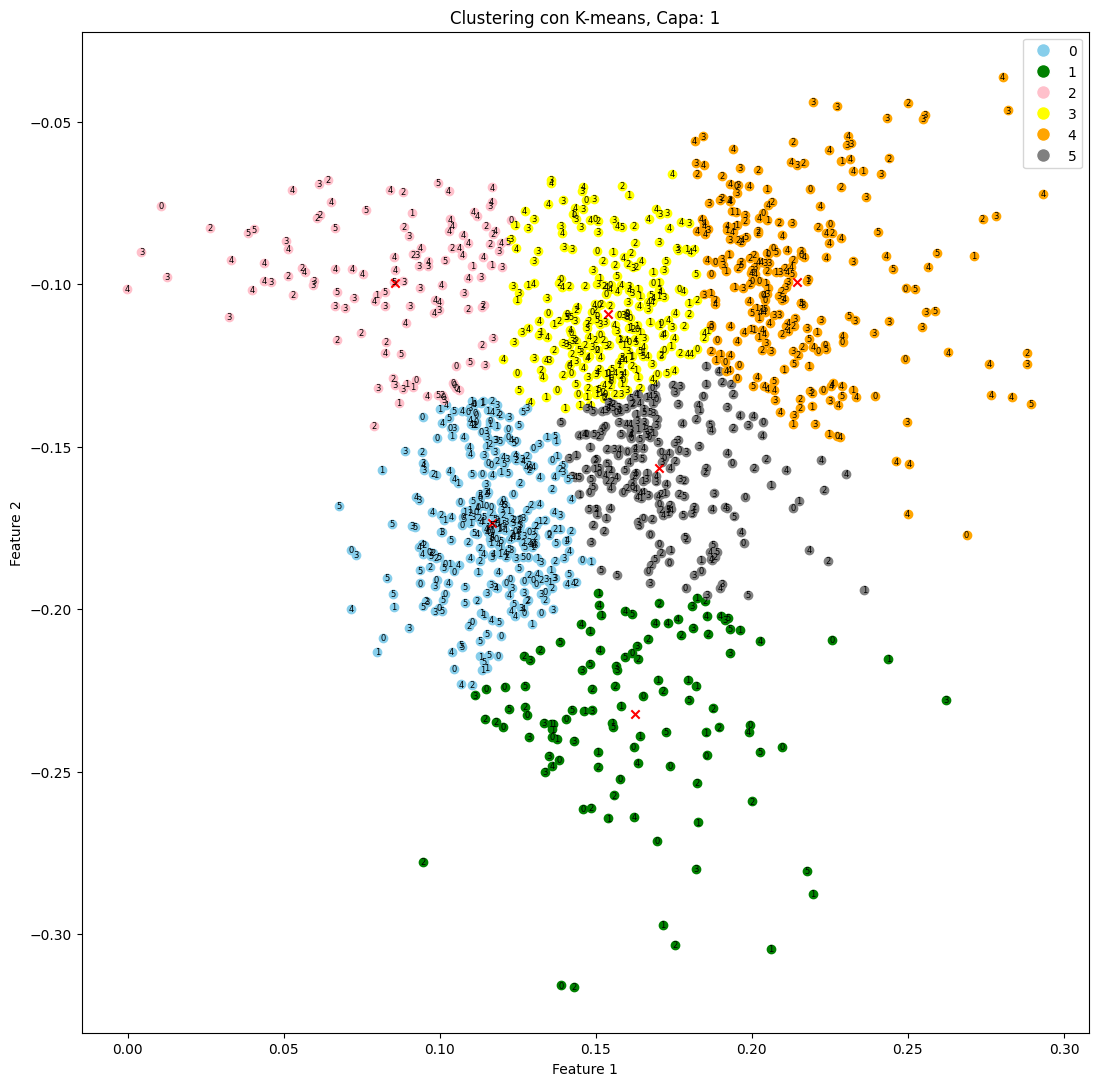

In [ ]:
clustering_kmeans(6, vectors_per_layer, 0, round_labels) #42

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


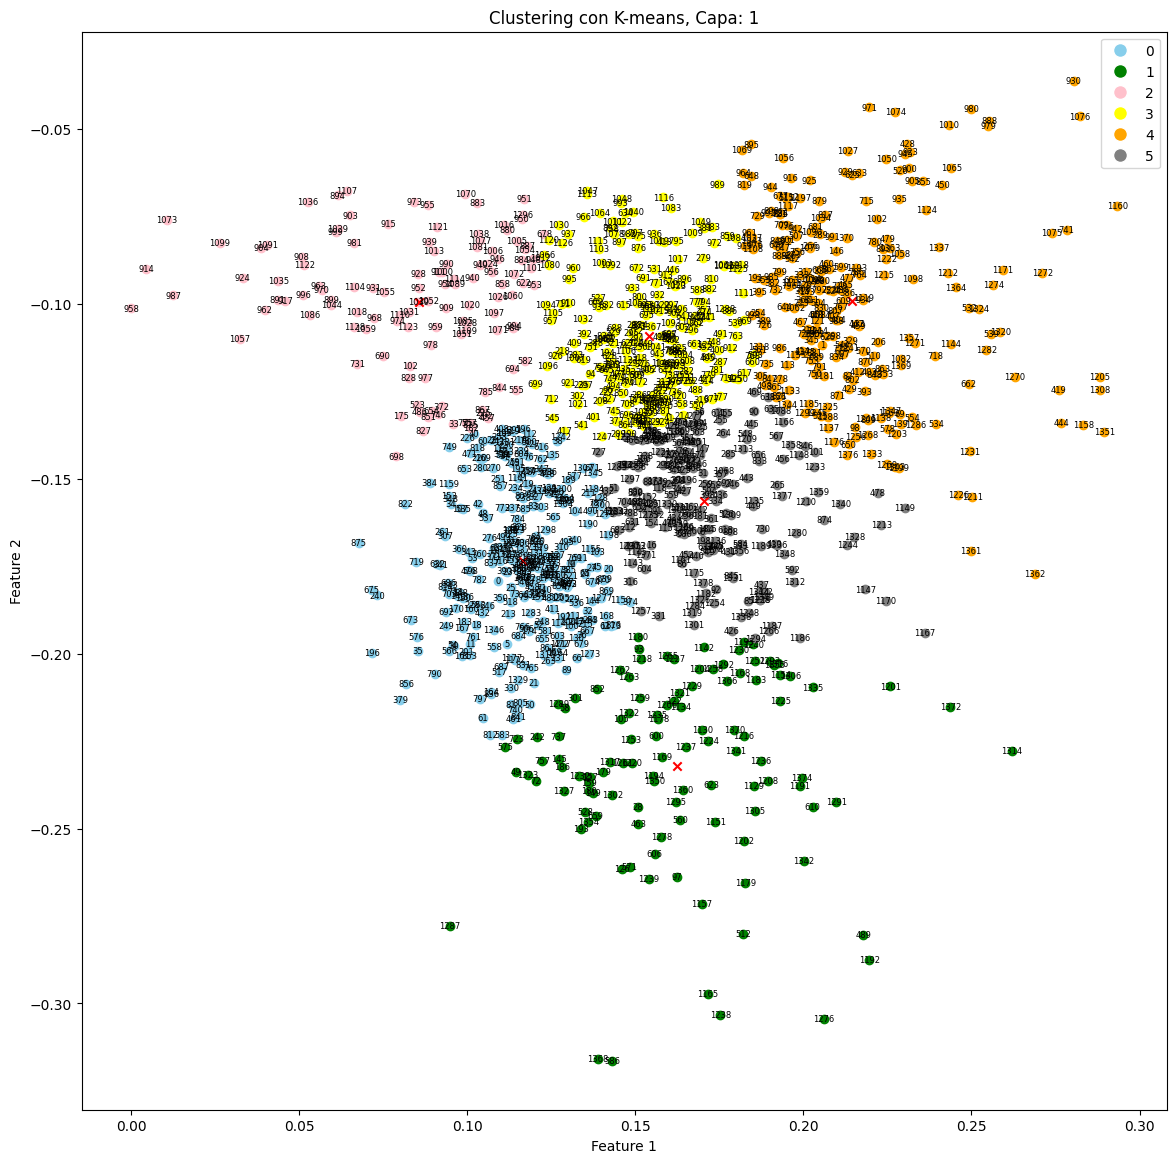

In [ ]:
positions, cluster_labels = clustering_kmeans_positions(6, vectors_per_layer, 0, round_labels, cluster = 0, plot_size=(14,14))

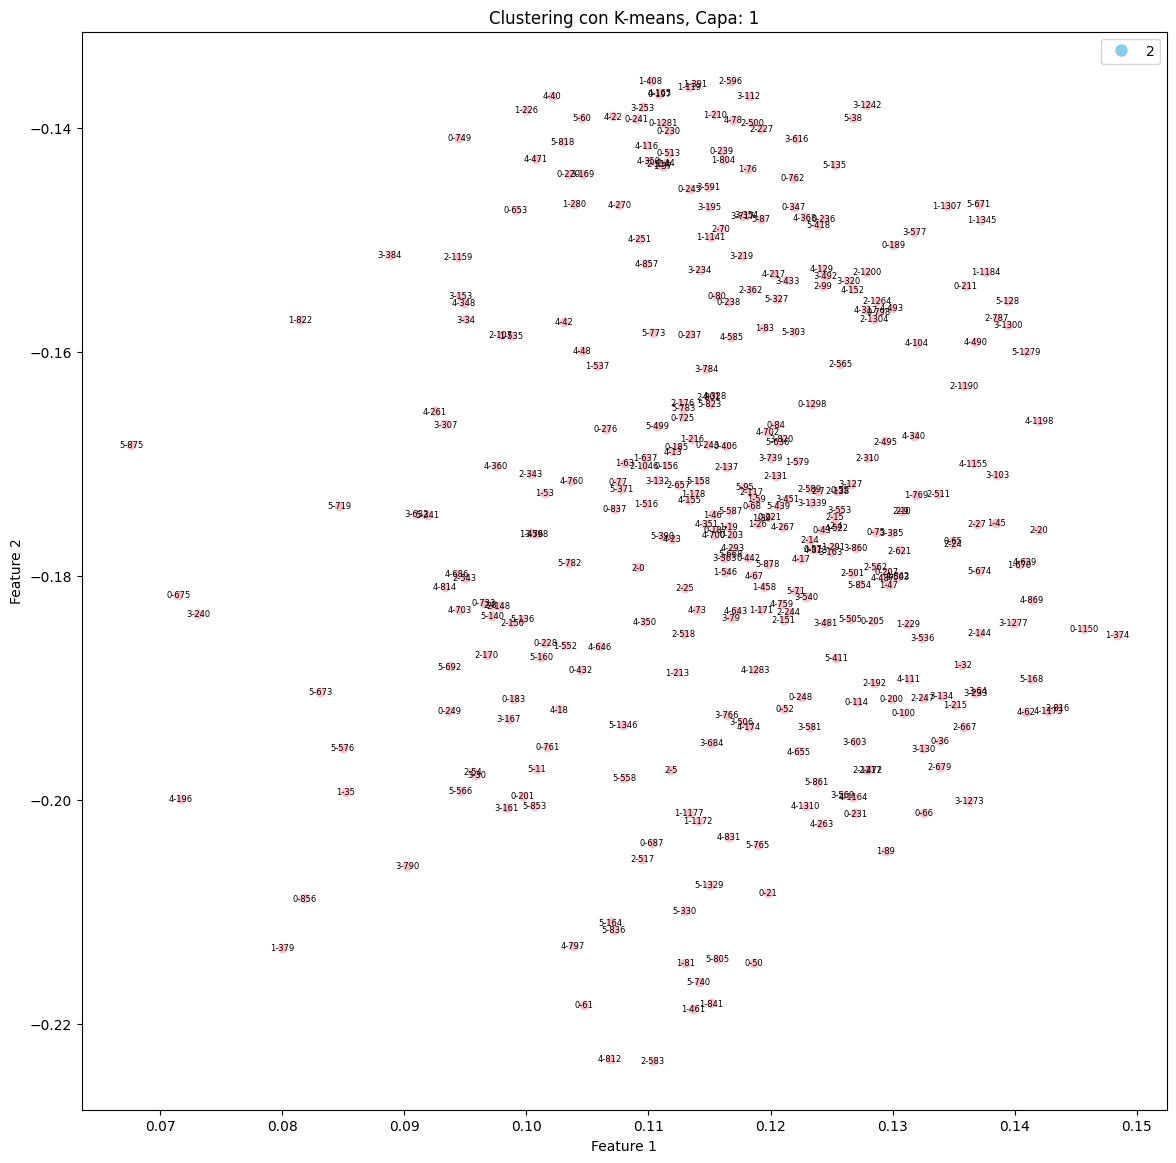

In [ ]:
#0 verde
#1 amarillo
# 2 azul cielo
# 3 rosa
# 4 naranja
# 5 gris
cluster = 2
plot_per_clusters(vectors_per_layer, cluster_labels, round_labels, positions, cluster =  cluster, layer = 0, plot_size=(14,14))

In [ ]:
for i in [604,255,1050,760,523,646,314,463,32,815,315,387,889,348,246,507,1141]:
  print(str(i) + ' ' + s1_test[i] + '     ' + s2_test[i] + ' ' + str(target_test[i]))

604 The cats are running through the grass.     Some dogs running through the park.
 2.0
255 A man with a bicycle at a coffee house.     Man walking bicycle to patio of a coffee shop.
 3.2
1050 The attack seemed similar to others staged near foreign compounds in Riyadh on May 12.     The attack seemed similar to attacks staged near foreign compounds in Riyadh on May 12, for which officials have also blamed al-Qaida.
 3.6
760 I was in a similar situation.     I am in a similar situation. 4.0
523 Blond boy jumping onto deck.     A boy jumping down a wet inflatable slide.
 2.0
646 To give this an answer:     I'll answer this question: 4.0
314 Home office space with bright green walls and artwork.     An office with multiple desks and green walls.
 3.4
463 Three children playing in snow.     Three children playing in hay
 2.4
32 A woman is wrapping tofu.     A woman is balling dough.
 1.4
815 You are on the right path.     You're right on about the sample definition. 0.0
315 A black and wh

In [ ]:
print(vectors_per_layer[2][9])
print(vectors_per_layer[2][10])

[-0.12931982 -0.10156181]
[-0.12931982 -0.10156181]


In [ ]:
print(len(positions[cluster]))
for i in positions[cluster]:
  print(str(i) + ' ' + s1_test[i] + '     ' + s2_test[i] + ' ' + str(target_test[i]))

355
0 A girl is styling her hair.     A girl is brushing her hair.
 2.5
4 A man is playing a harp.     A man is playing a keyboard.
 1.5
5 A woman is cutting onions.     A woman is cutting tofu.
 1.8
7 A man is playing the drums.     A man is playing the guitar.
 2.2
8 A man is playing guitar.     A lady is playing the guitar.
 2.2
9 A man is playing a guitar.     A man is playing a trumpet.
 1.714
10 A man is playing a guitar.     A man is playing a trumpet.
 1.714
11 A man is cutting an onion.     A man cuts an onion.
 5.0
13 A man is slicing open a fish.     A man is cutting up a fish.
 4.4
14 A man is slicing a tomato.     A man is slicing a bun.
 2.0
15 A man is playing a guitar.     A man is playing a keyboard.
 1.8
17 A man is singing and playing a guitar.     A man is playing a guitar.
 3.6
18 A man attacks a woman.     A man slaps a woman.
 3.6
19 A man is driving a car.     A man is riding a horse.
 1.2
20 A woman is cutting tofu.     A woman is cutting an onion.
 2.4
21 The 

In [ ]:
positions[0]

array([   1,   31,   86,   90,   93,   96,   98,  101,  109,  110,  113,
        136,  139,  141,  143,  146,  194,  223,  227,  244,  256,  265,
        266,  269,  272,  273,  274,  278,  281,  286,  291,  296,  297,
        299,  303,  305,  306,  308,  312,  318,  324,  325,  329,  339,
        346,  348,  352,  361,  365,  374,  378,  382,  383,  385,  389,
        392,  400,  404,  407,  409,  414,  421,  423,  424,  430,  447,
        451,  459,  467,  468,  469,  474,  487,  491,  494,  497,  498,
        504,  507,  508,  518,  525,  531,  538,  547,  556,  561,  568,
        570,  578,  588,  593,  597,  608,  617,  620,  621,  622,  627,
        629,  638,  642,  647,  648,  651,  660,  663,  675,  677,  680,
        681,  682,  687,  688,  689,  695,  698,  706,  710,  711,  713,
        715,  719,  721,  724,  725,  726,  729,  733,  736,  738,  743,
        744,  747,  748,  751,  752,  754,  755,  756,  763,  767,  768,
        776,  777,  781,  786,  792,  794,  799,  8

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.006844581717117979
Índice de Jaccard: 0.12205044751830757
Coeficiente de Dice: 0.21754894851341552
Índice de Silueta: 0.35310128
Homogeneidad: 0.01978103562601272
Completitud: 0.020421357978128527
Valor-F: 0.020096097445068944
Índice de Calinski-Harabasz: 1076.318987755677
Índice de Davies-Bouldin: 0.855640817127412
Coeficiente de Diversidad de Dunn: 0.0028635778


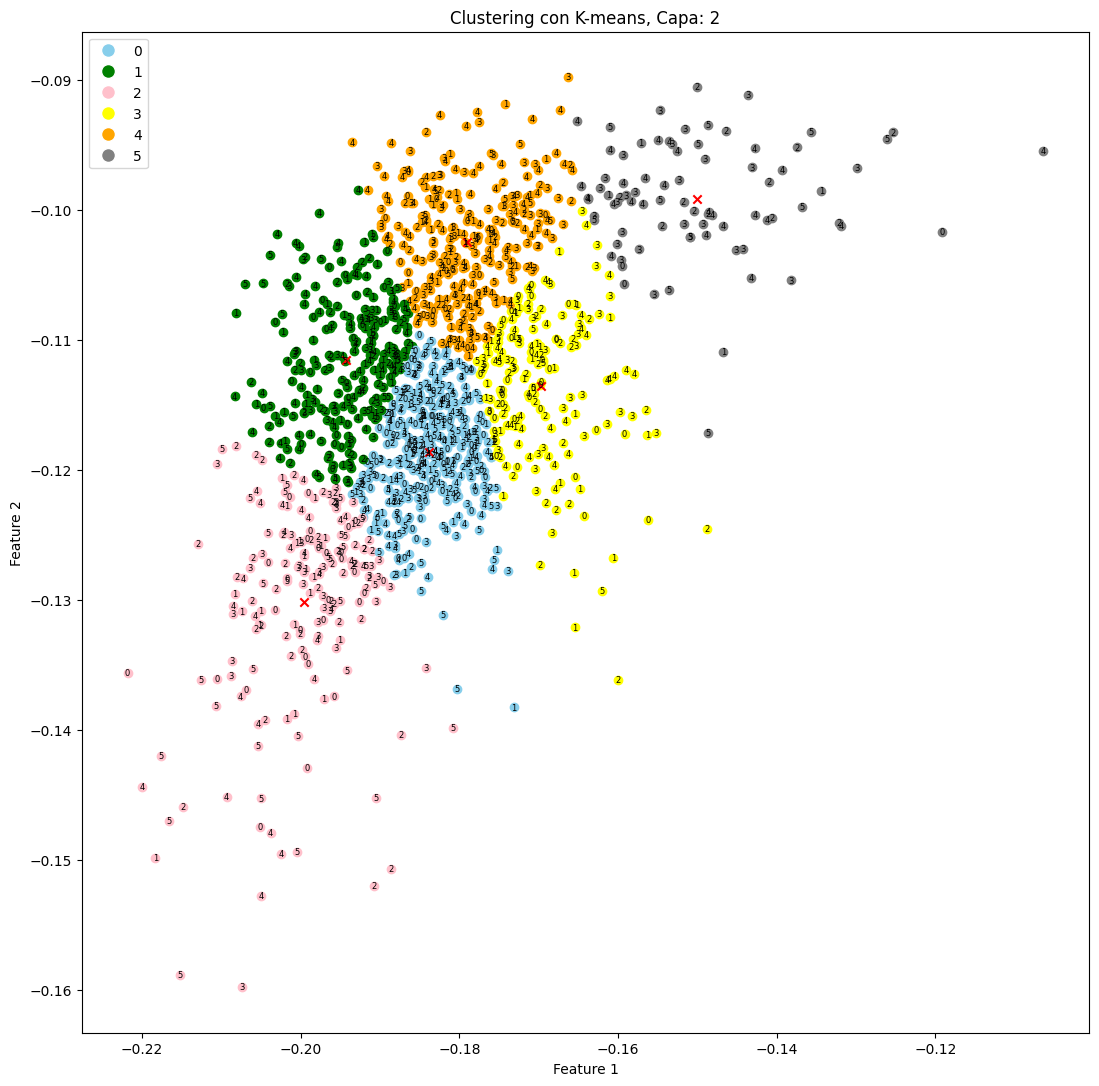

In [ ]:
clustering_kmeans(6, vectors_per_layer, 1, round_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.0052583611483039815
Índice de Jaccard: 0.11977263499796996
Coeficiente de Dice: 0.21392313270485863
Índice de Silueta: 0.3648826
Homogeneidad: 0.02388684574747625
Completitud: 0.026182880554719817
Valor-F: 0.024982218806646698
Índice de Calinski-Harabasz: 1159.7568747762678
Índice de Davies-Bouldin: 0.824168100075883
Coeficiente de Diversidad de Dunn: 0.0052035945


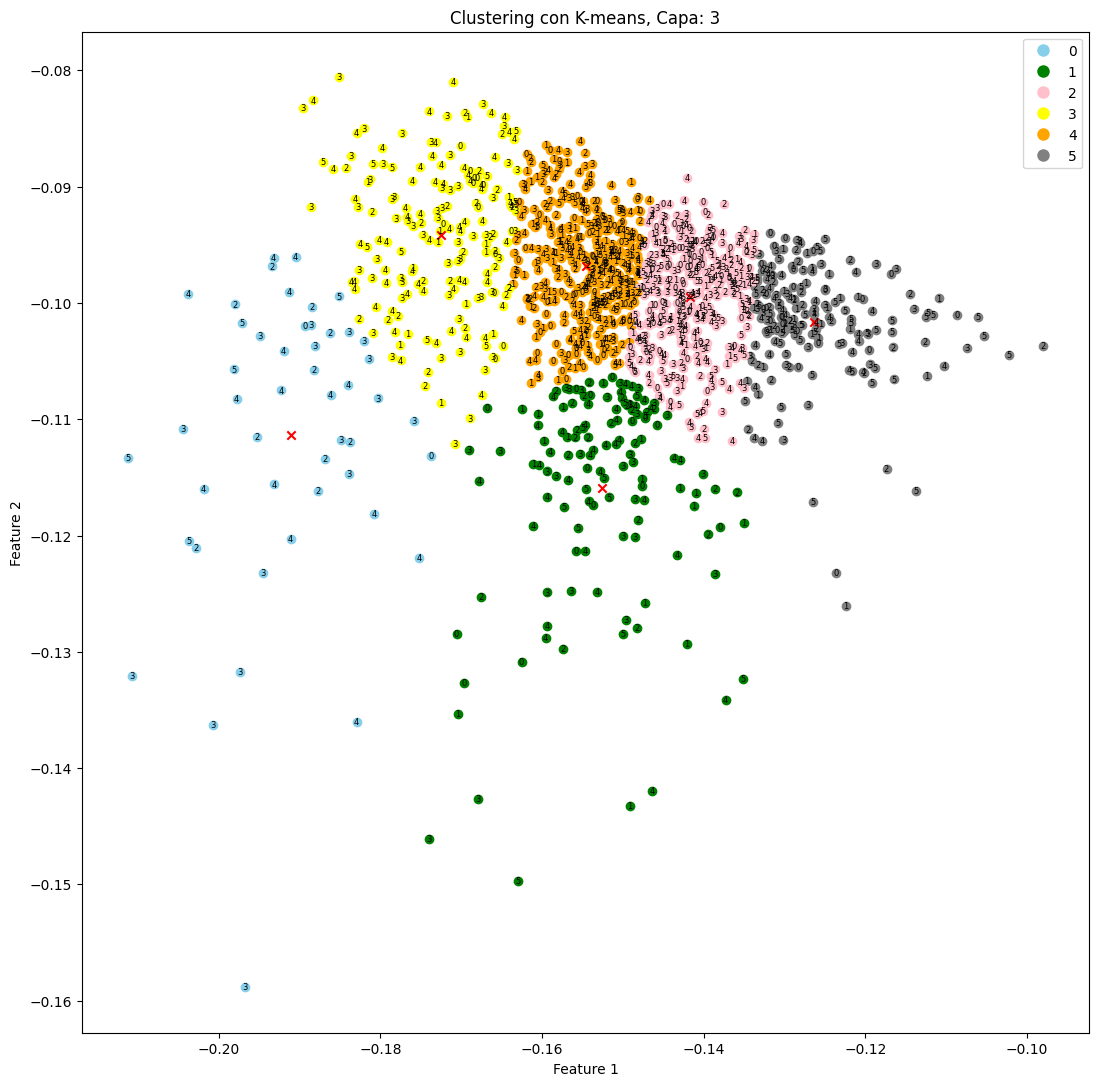

In [ ]:
clustering_kmeans(6, vectors_per_layer, 2, round_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.009893371469123738
Índice de Jaccard: 0.12571428571428572
Coeficiente de Dice: 0.2233502538071066
Índice de Silueta: 0.34314802
Homogeneidad: 0.03276758784497864
Completitud: 0.0335165591416365
Valor-F: 0.033137842029007894
Índice de Calinski-Harabasz: 1808.080012720461
Índice de Davies-Bouldin: 0.8915550214805247
Coeficiente de Diversidad de Dunn: 0.0054575284


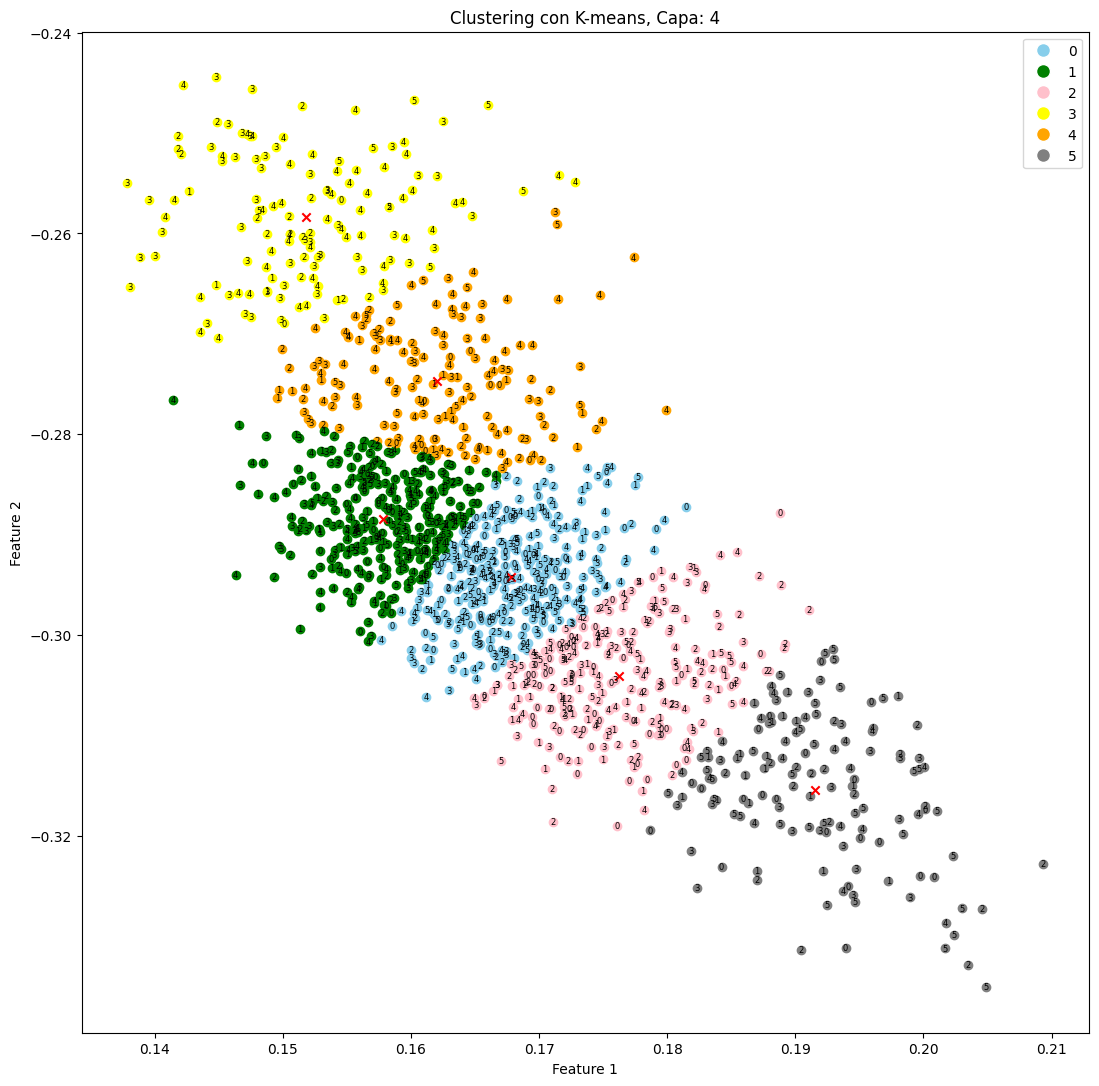

In [ ]:
clustering_kmeans(6, vectors_per_layer, 3, round_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.008949483785605311
Índice de Jaccard: 0.12617394855042874
Coeficiente de Dice: 0.224075416968818
Índice de Silueta: 0.3296029
Homogeneidad: 0.02222338623674414
Completitud: 0.02222011066134689
Valor-F: 0.022221748328337256
Índice de Calinski-Harabasz: 1189.5522282849506
Índice de Davies-Bouldin: 0.9164396073968372
Coeficiente de Diversidad de Dunn: 0.0055645555


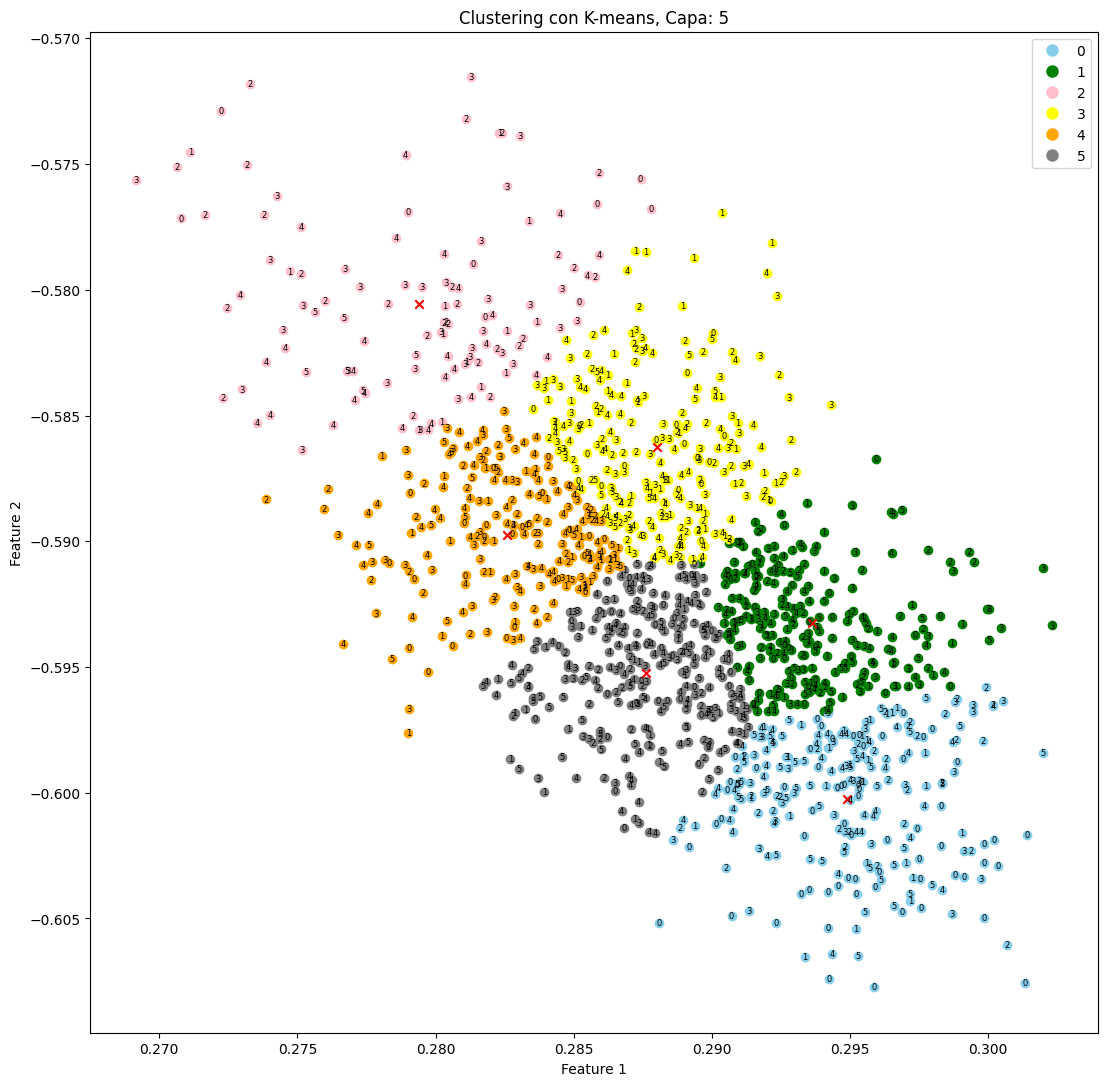

In [ ]:
clustering_kmeans(6, vectors_per_layer, 4, round_labels )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.02298509761518567
Índice de Jaccard: 0.14202898550724638
Coeficiente de Dice: 0.24873096446700507
Índice de Silueta: 0.32266045
Homogeneidad: 0.04562421508403698
Completitud: 0.04598925986352557
Valor-F: 0.04580601019162596
Índice de Calinski-Harabasz: 940.4909196524596
Índice de Davies-Bouldin: 0.9010715127497365
Coeficiente de Diversidad de Dunn: 0.003533022


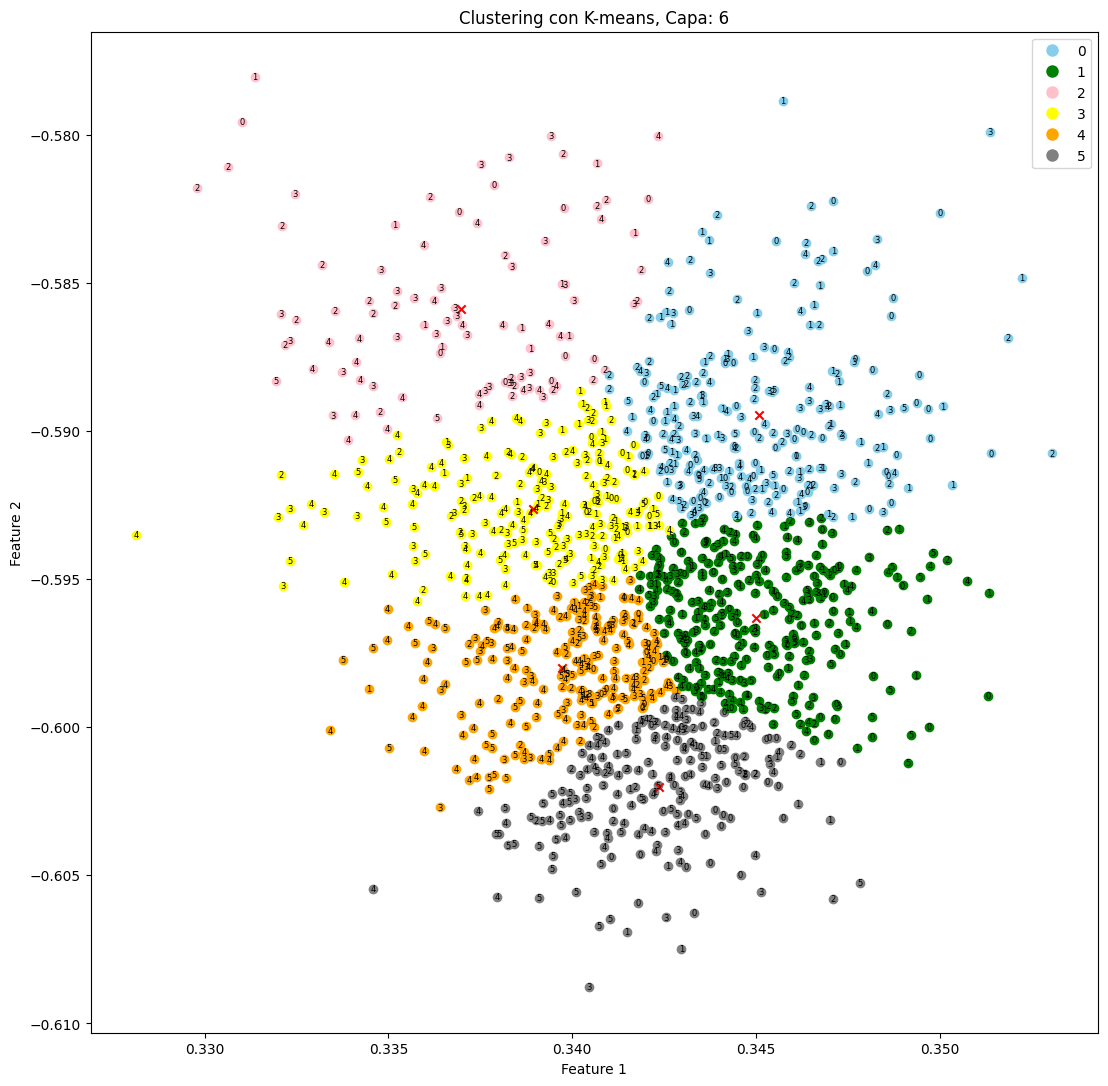

In [ ]:
clustering_kmeans(6, vectors_per_layer, 5, round_labels )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.01779294231572722
Índice de Jaccard: 0.14014055394791236
Coeficiente de Dice: 0.24583031182015955
Índice de Silueta: 0.33519197
Homogeneidad: 0.0409378635450592
Completitud: 0.04163184100234197
Valor-F: 0.041281935921305614
Índice de Calinski-Harabasz: 1756.2717937544808
Índice de Davies-Bouldin: 0.9374313944246612
Coeficiente de Diversidad de Dunn: 0.006089593


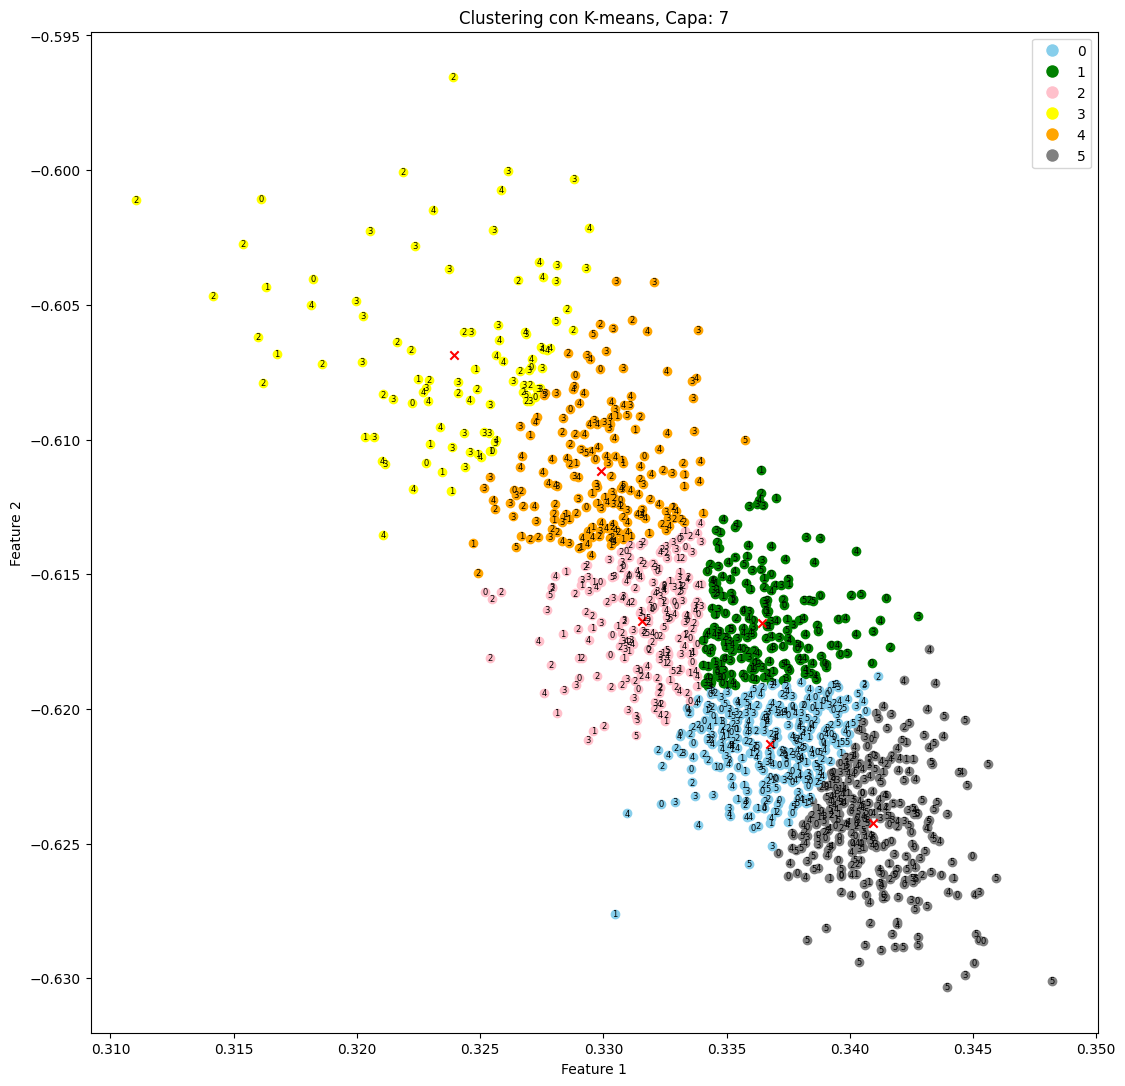

In [ ]:
clustering_kmeans(6, vectors_per_layer, 6, round_labels )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.024695832337794925
Índice de Jaccard: 0.15156576200417538
Coeficiente de Dice: 0.2632342277012328
Índice de Silueta: 0.4061887
Homogeneidad: 0.05925098167098867
Completitud: 0.060288659479347737
Valor-F: 0.05976531673349861
Índice de Calinski-Harabasz: 3511.3307405544133
Índice de Davies-Bouldin: 0.7434477556449073
Coeficiente de Diversidad de Dunn: 0.0057386514


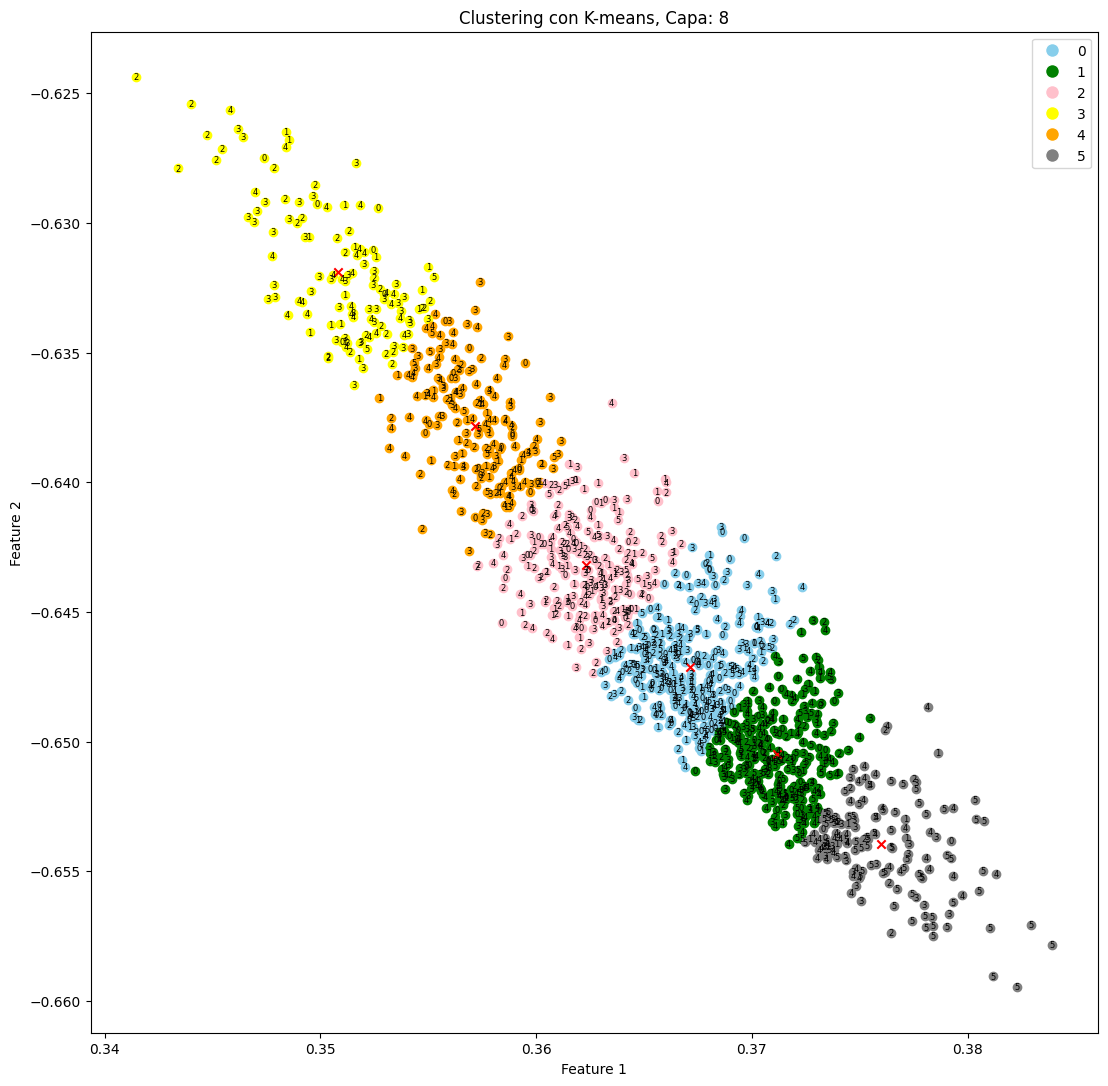

In [ ]:
clustering_kmeans(6, vectors_per_layer, 7, round_labels )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.037164173520220375
Índice de Jaccard: 0.15108514190317196
Coeficiente de Dice: 0.2625090645395214
Índice de Silueta: 0.42886314
Homogeneidad: 0.07576562661856051
Completitud: 0.07953615208349782
Valor-F: 0.07760511762065828
Índice de Calinski-Harabasz: 3229.5031475871697
Índice de Davies-Bouldin: 0.6891178765020215
Coeficiente de Diversidad de Dunn: 0.0029979981


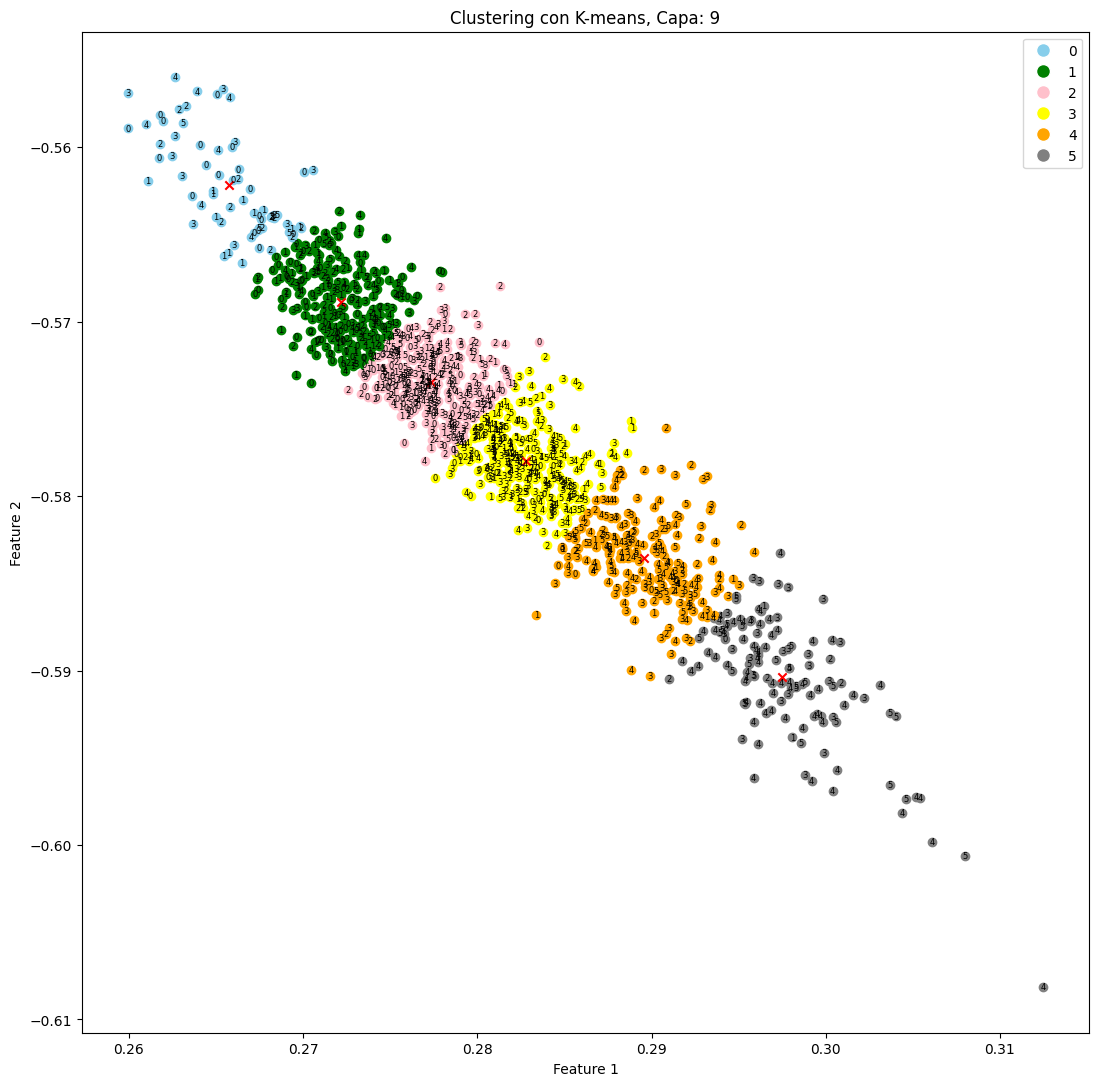

In [ ]:
clustering_kmeans(6, vectors_per_layer, 8, round_labels )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.046637060057705335
Índice de Jaccard: 0.15785054575986565
Coeficiente de Dice: 0.2726613488034808
Índice de Silueta: 0.38221356
Homogeneidad: 0.09950805340767714
Completitud: 0.10480076724107193
Valor-F: 0.10208585523303473
Índice de Calinski-Harabasz: 1534.7761011445743
Índice de Davies-Bouldin: 0.7954467498371476
Coeficiente de Diversidad de Dunn: 0.009017952


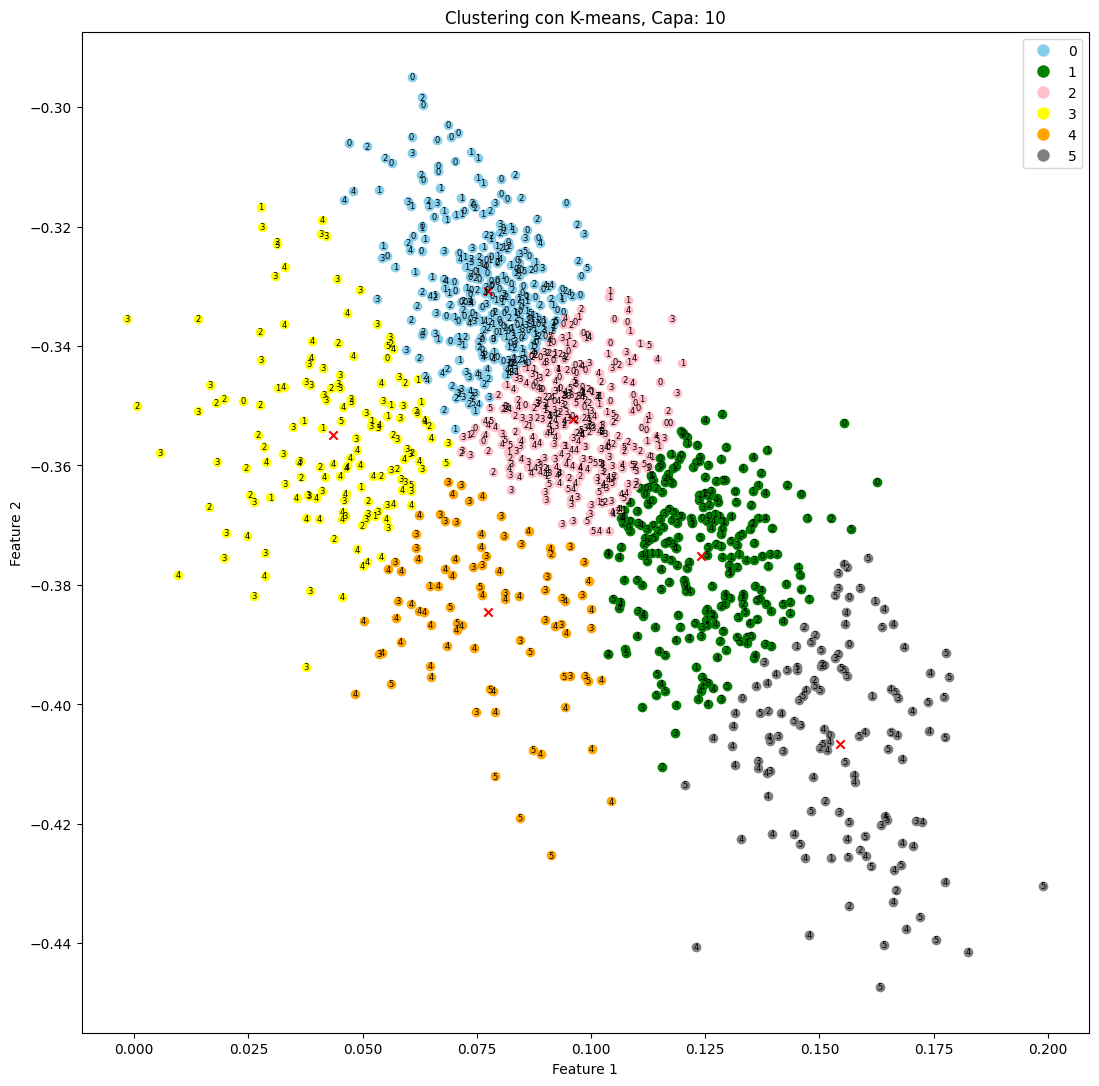

In [ ]:
clustering_kmeans(6, vectors_per_layer, 9, round_labels )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): 0.0089340879320898
Índice de Jaccard: 0.1280163599182004
Coeficiente de Dice: 0.22697606961566352
Índice de Silueta: 0.47843668
Homogeneidad: 0.015712012243649567
Completitud: 0.016806356602615743
Valor-F: 0.016240770375649787
Índice de Calinski-Harabasz: 12748.161639835216
Índice de Davies-Bouldin: 0.6264640149180455
Coeficiente de Diversidad de Dunn: 0.003351914


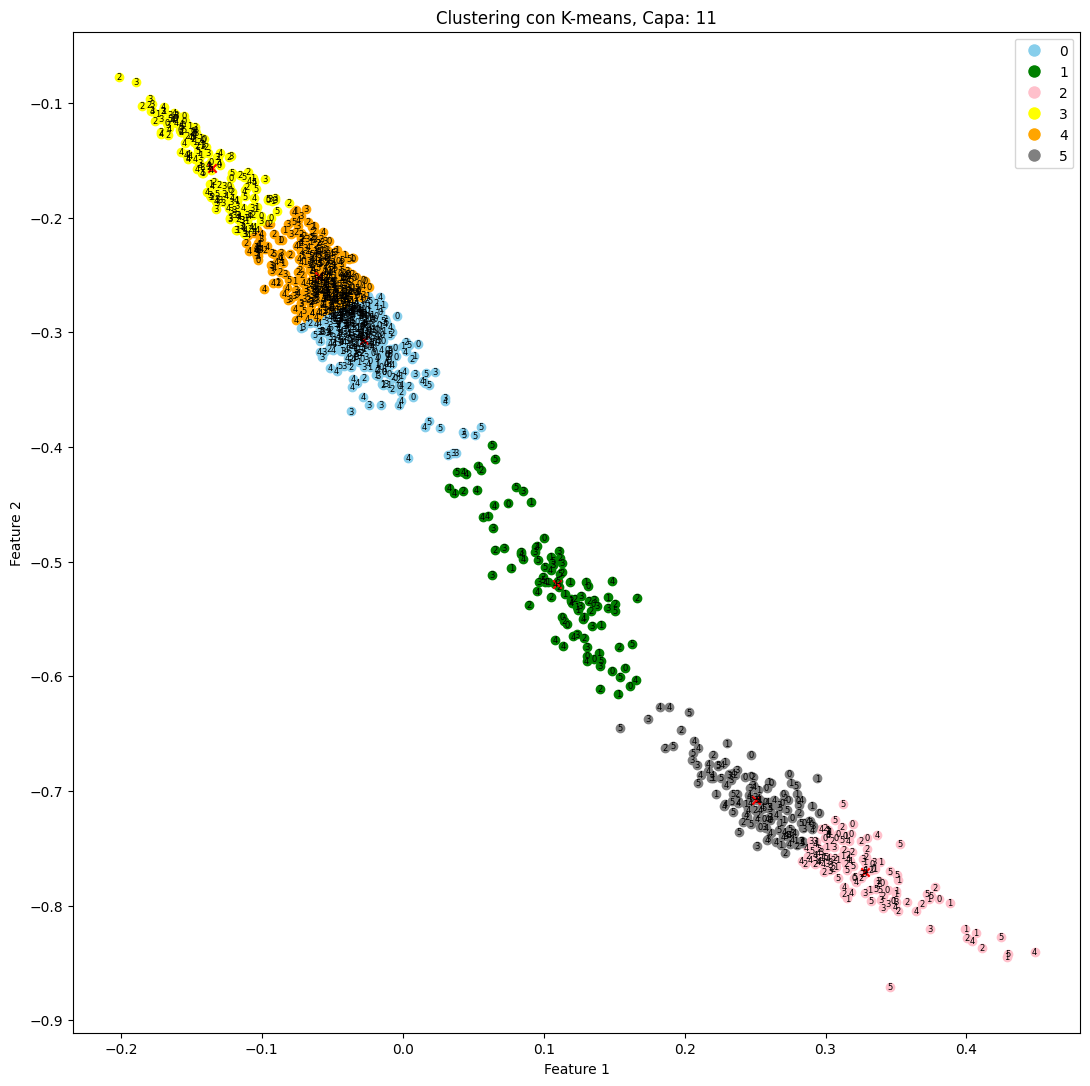

In [ ]:
clustering_kmeans(6, vectors_per_layer, 10, round_labels )

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ARI (Adjusted Rand Index): -0.002681726370472261
Índice de Jaccard: 0.11434343434343434
Coeficiente de Dice: 0.20522117476432195
Índice de Silueta: 0.69706917
Homogeneidad: 0.01896765710794571
Completitud: 0.02339050661191013
Valor-F: 0.020948174804276347
Índice de Calinski-Harabasz: 13658.522878962745
Índice de Davies-Bouldin: 0.4303771603683519
Coeficiente de Diversidad de Dunn: 0.008784174


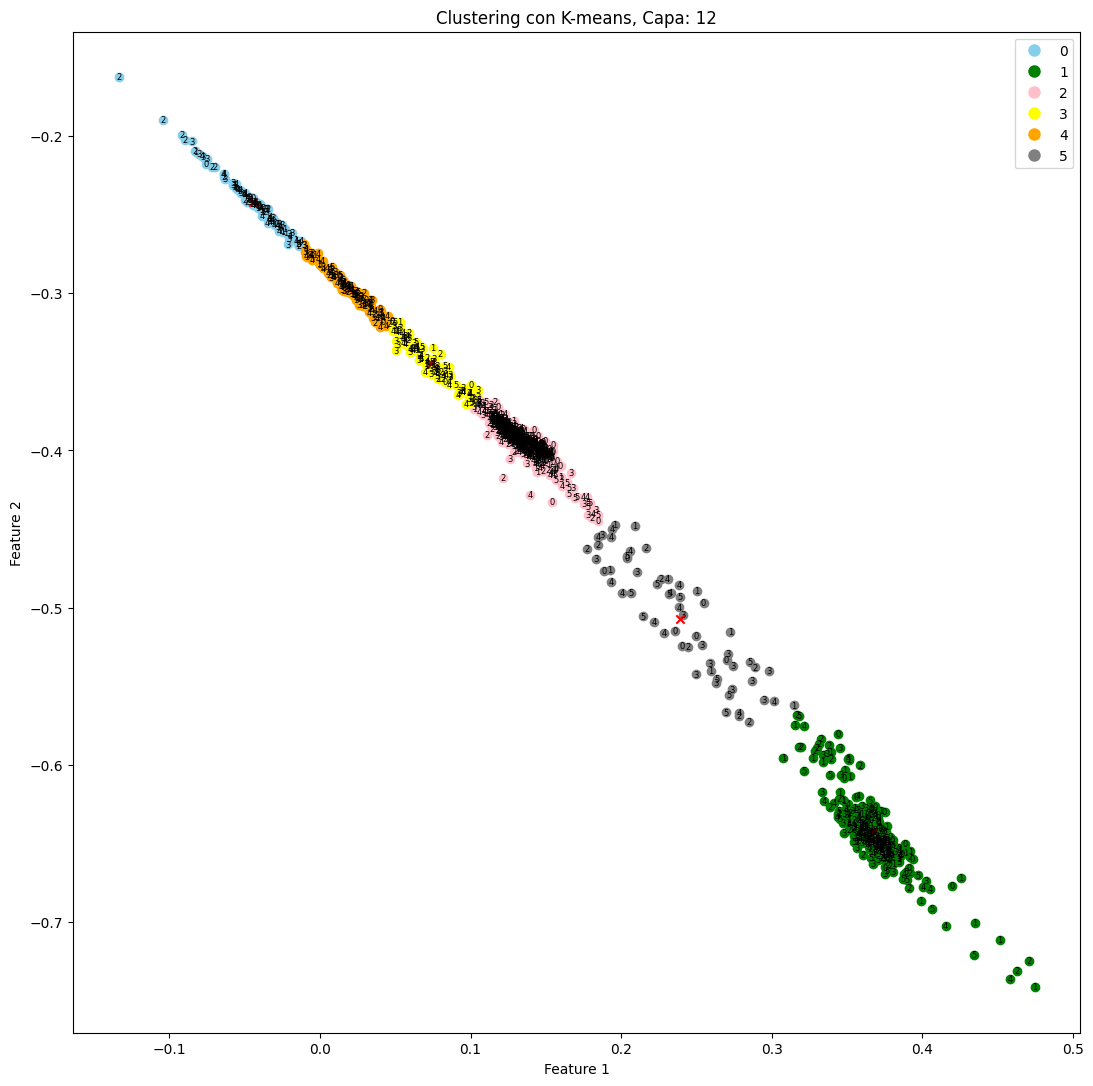

In [ ]:
clustering_kmeans(6, vectors_per_layer, 11, round_labels )

In [ ]:
def plot_all_layers_OneSent(vectors, num_sent, plot_size = (5.5,5.5)):
    vector_all_layers_OneSent = [vectors_per_layer[i][num_sent] for i in range(12)]
    #print(vector_all_layers_OneSent)
    plt.figure(figsize=plot_size)
    # Definir una lista de colores
    colors = ['skyblue', 'green', 'pink', 'yellow', 'orange', 'gray', 'purple', 'cyan', 'red', 'blue', 'olive', 'brown']
    labels = list(range(12))
    # Graficar los puntos con colores según la etiqueta
    for i in range(len(vector_all_layers_OneSent)):
        plt.scatter(vector_all_layers_OneSent[i][0], vector_all_layers_OneSent[i][1], color=colors[i], label = colors[i], s=100)
        plt.text(vector_all_layers_OneSent[i][0], vector_all_layers_OneSent[i][1], labels[i], fontsize=9, ha='center', va='center')
    # Agregar leyenda con los colores correspondientes a las etiquetas
    handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
    # Establecer leyenda personalizada
    plt.legend(handles=handles, labels=labels)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Sentencia número: {}, Similaridad: {}, 12 capas'.format(num_sent,labels_list[num_sent]))
    plt.show()


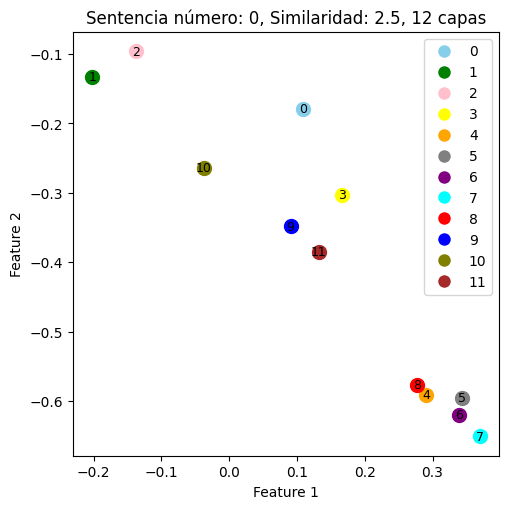

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 0)

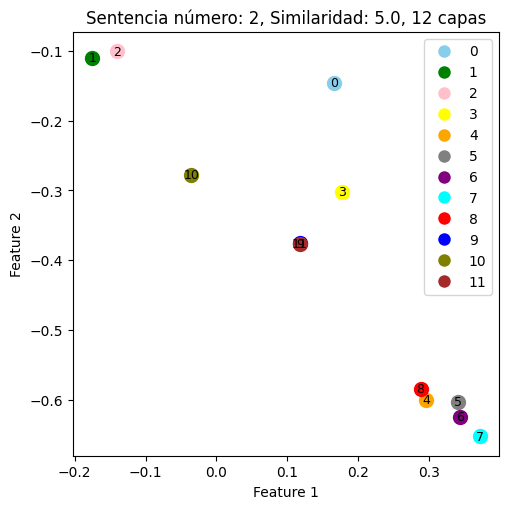

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 2)

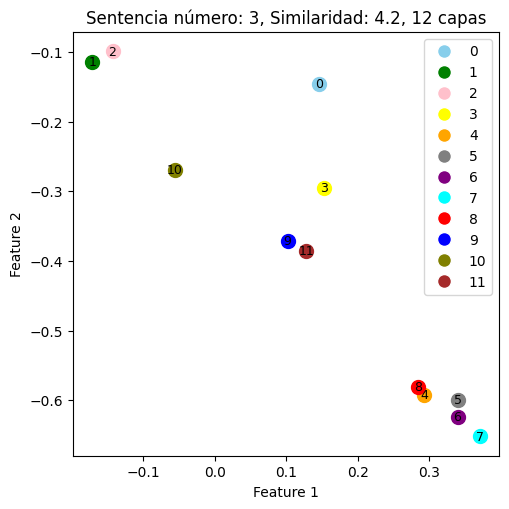

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 3)

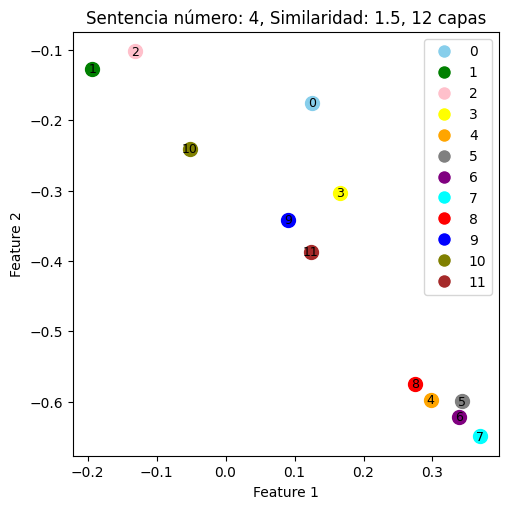

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 4)

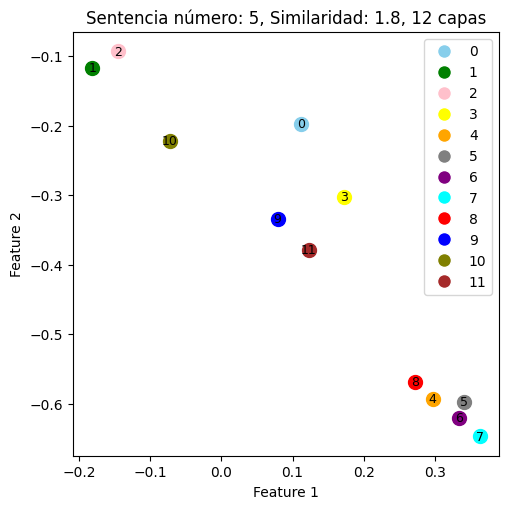

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 5)

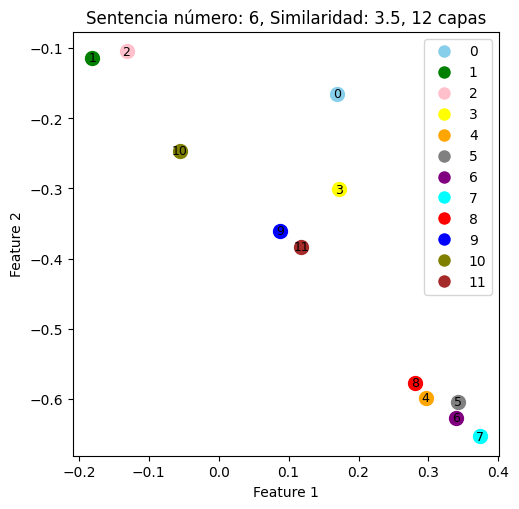

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 6)

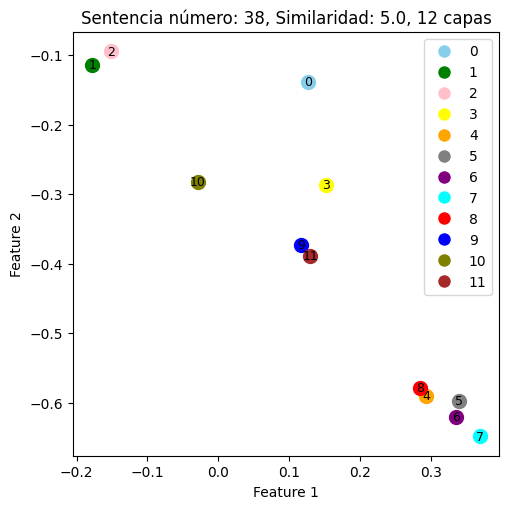

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 38)

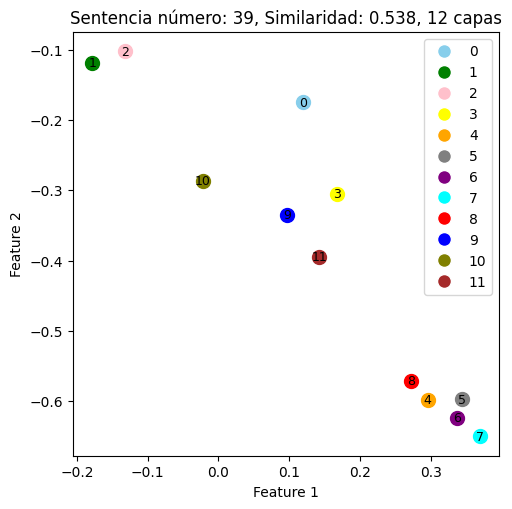

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 39)

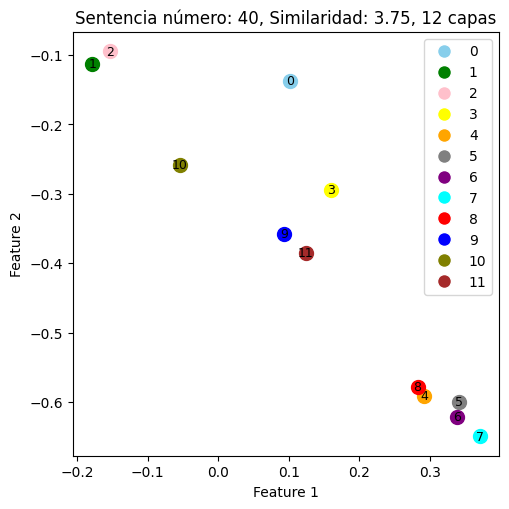

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 40)

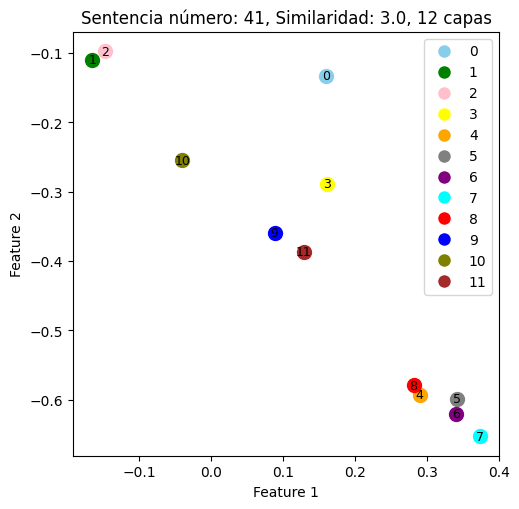

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 41)

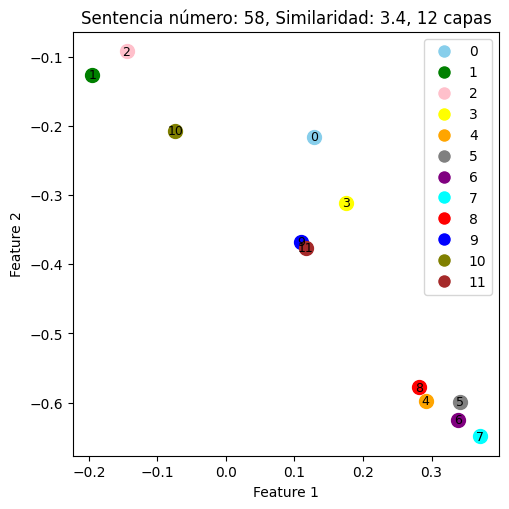

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 58)

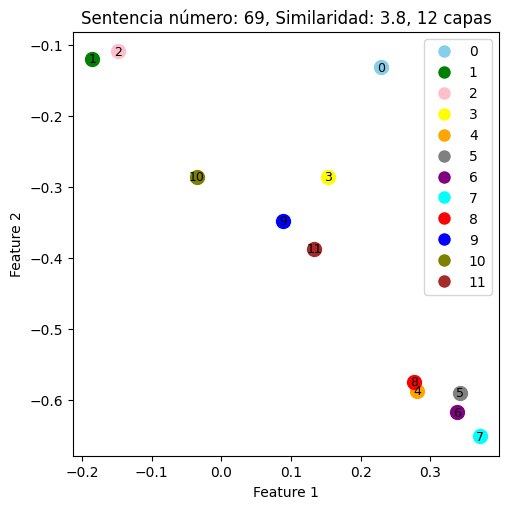

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 69)

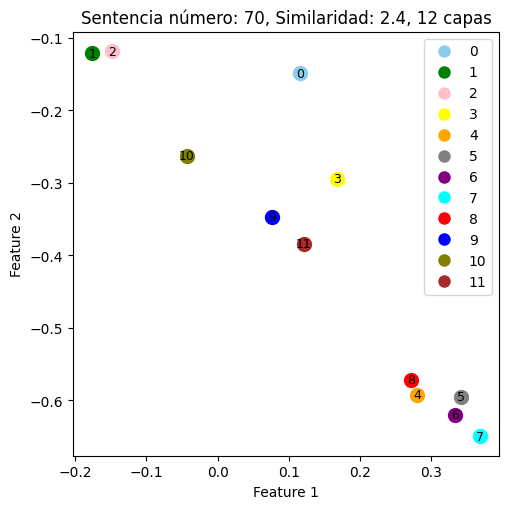

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 70)

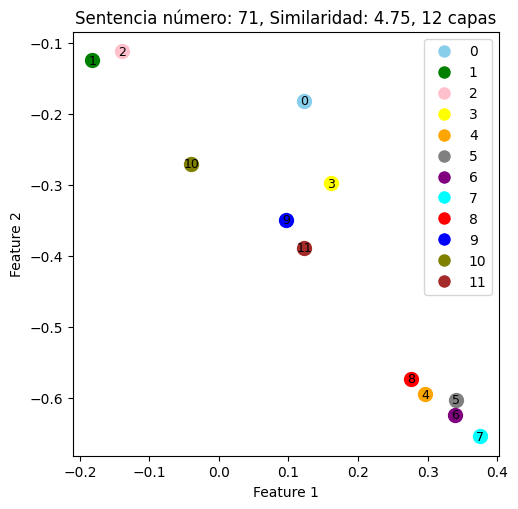

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 71) #predijo 3.8

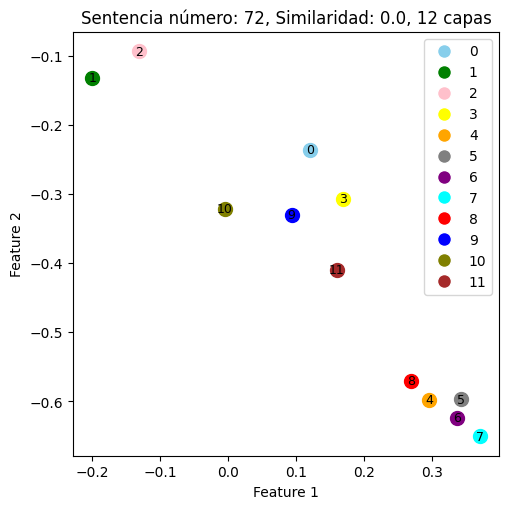

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 72)

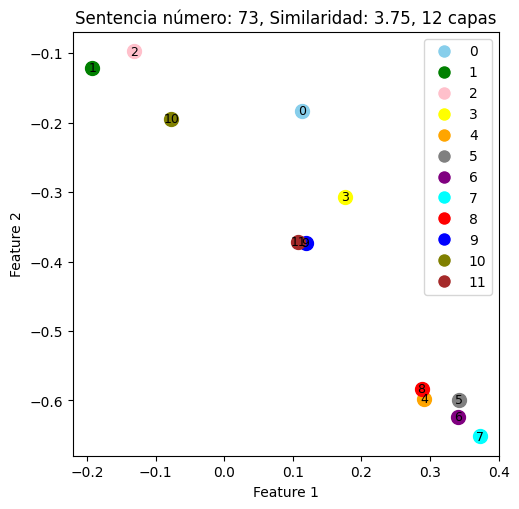

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 73)

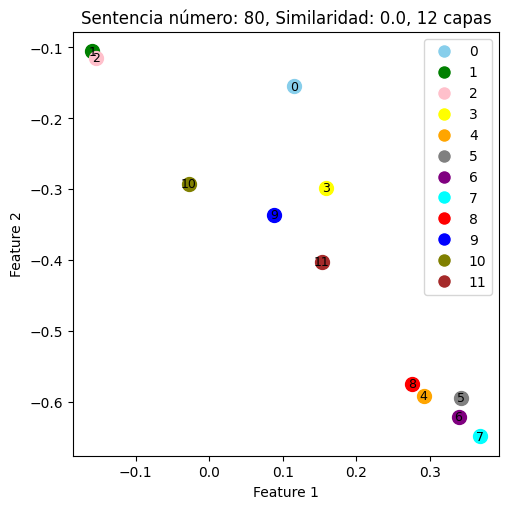

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 80)

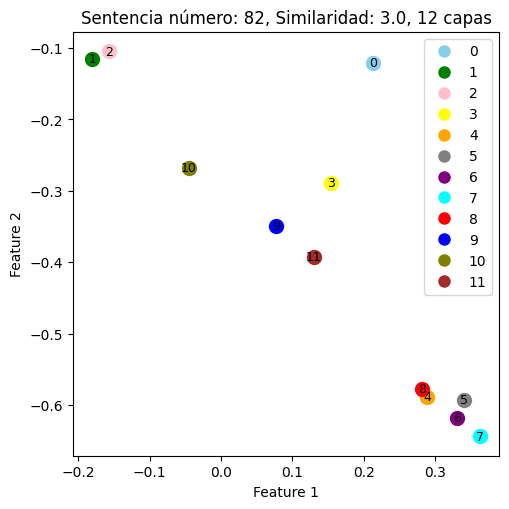

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 82)

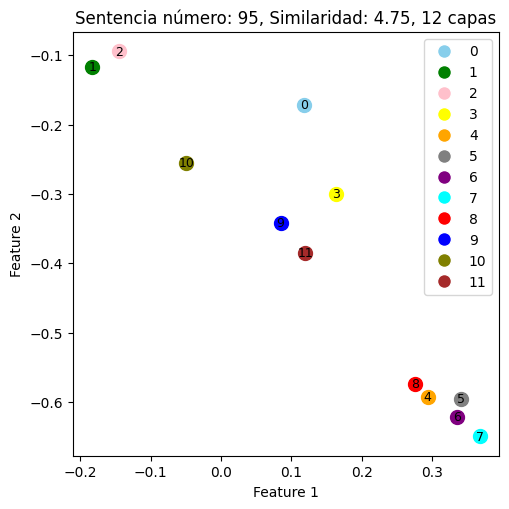

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 95)

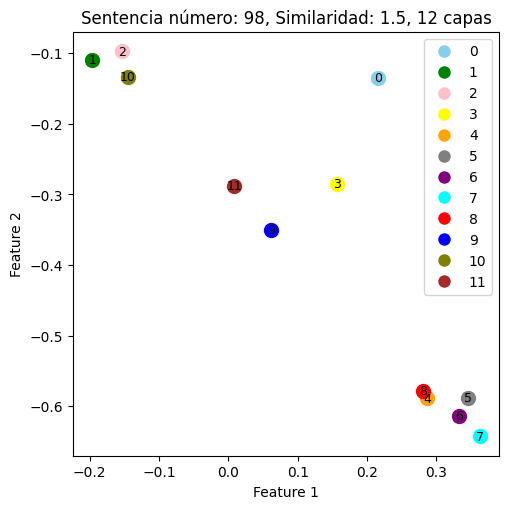

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 98)

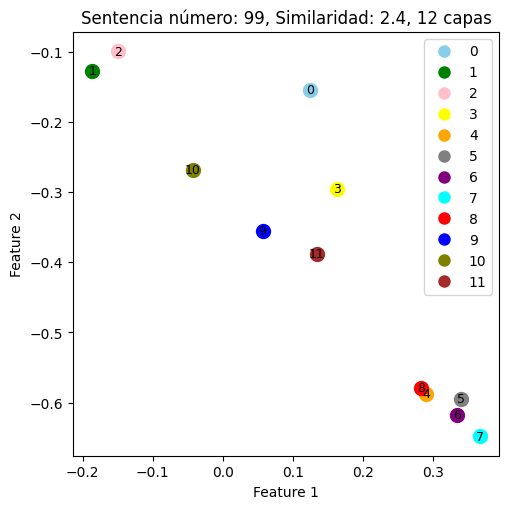

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 99)

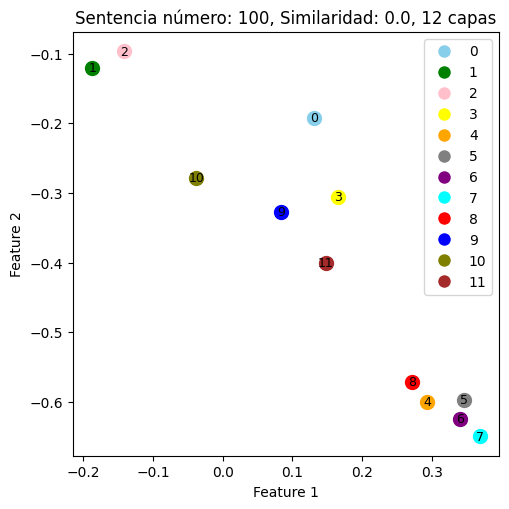

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 100)

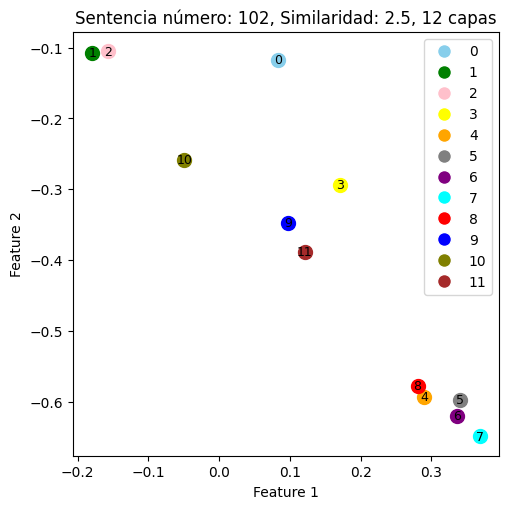

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 102)

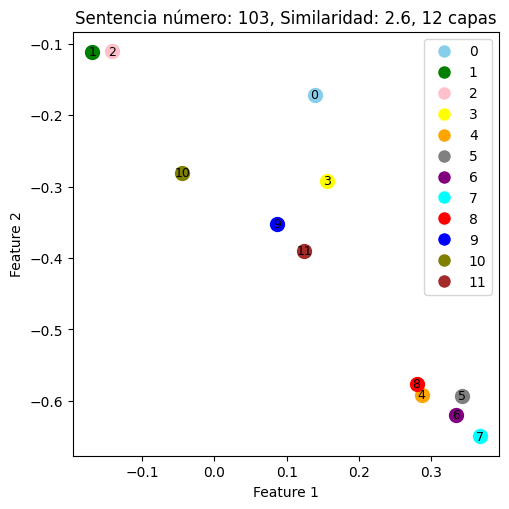

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 103)

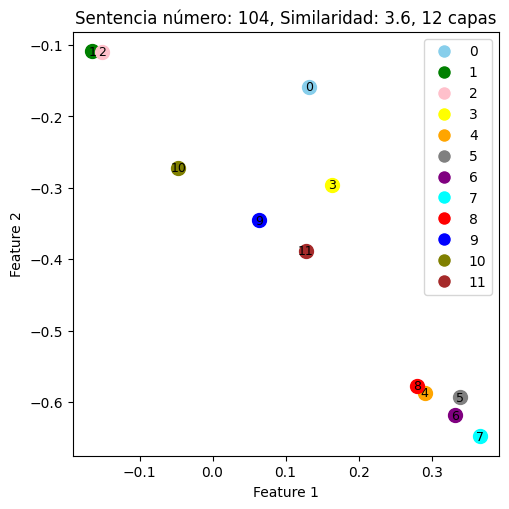

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 104)

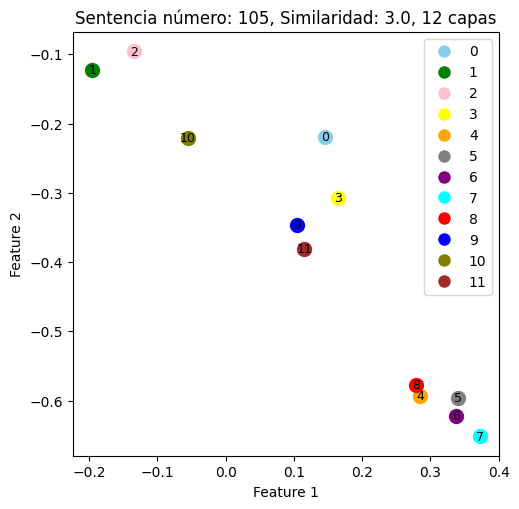

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 105)

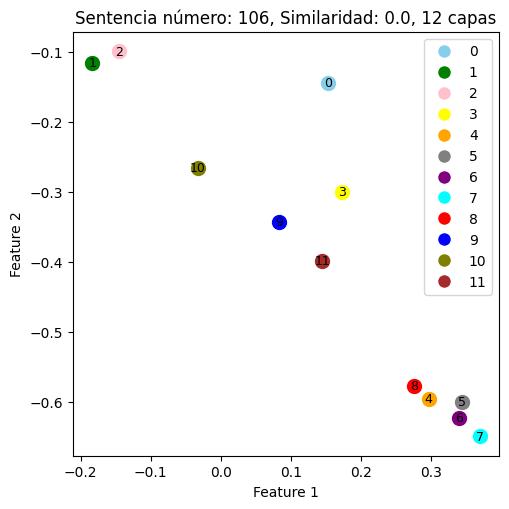

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 106)

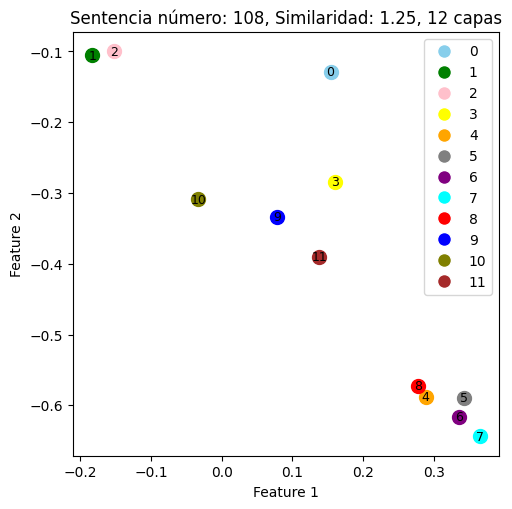

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 108)

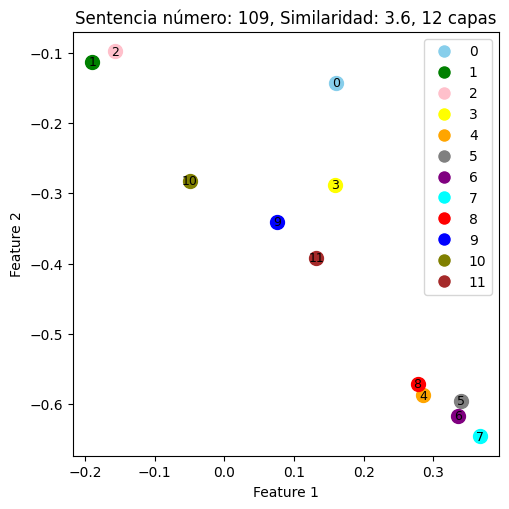

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 109)

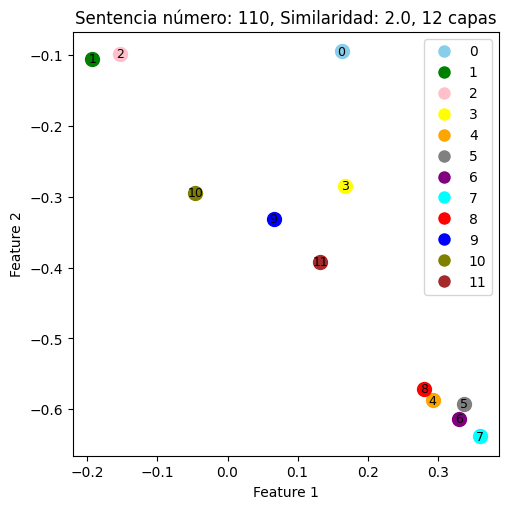

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 110)

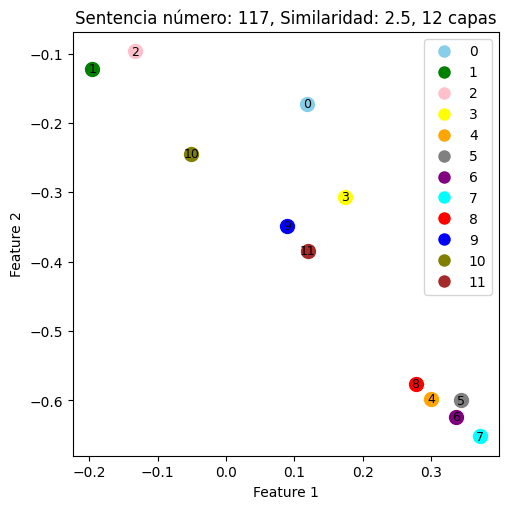

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 117)

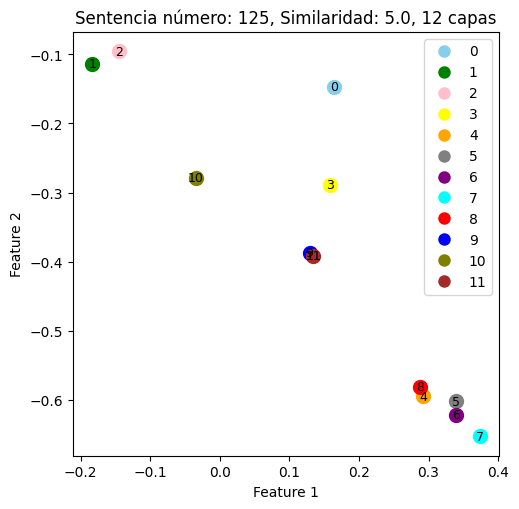

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 125)

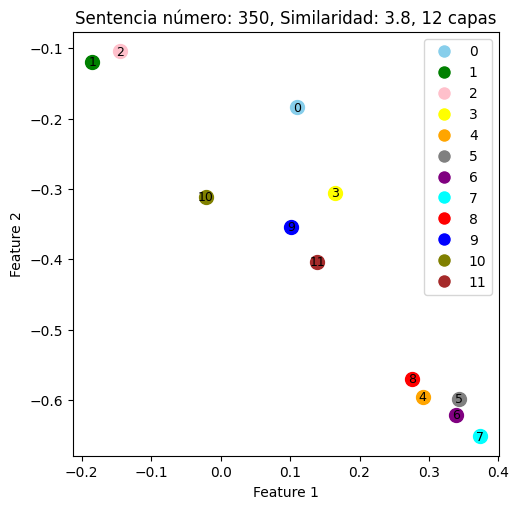

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 350)

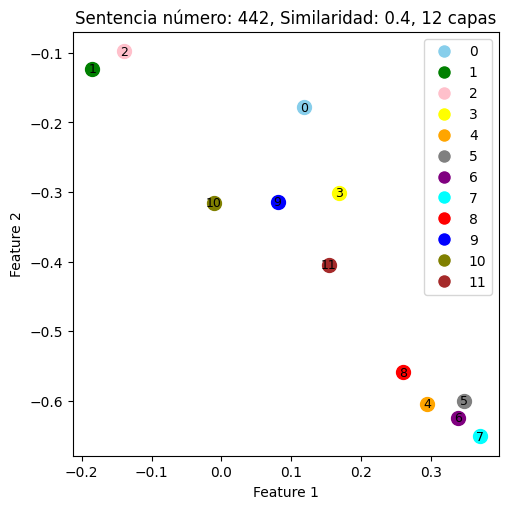

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 442)

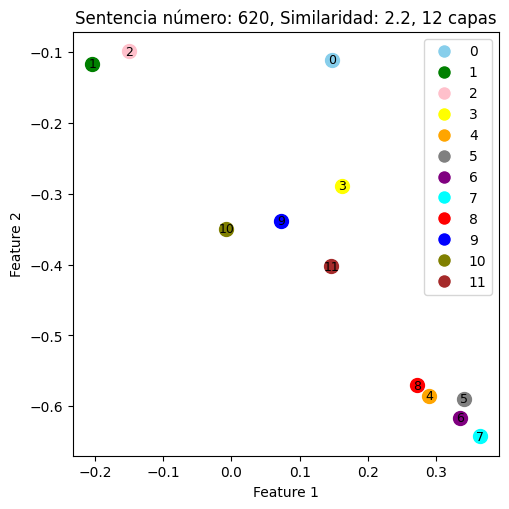

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 620)

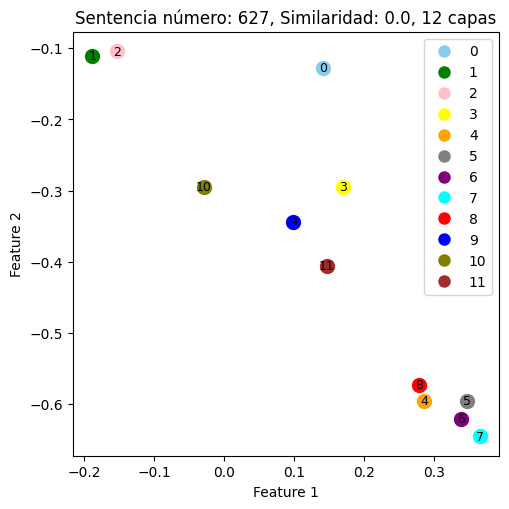

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 627)

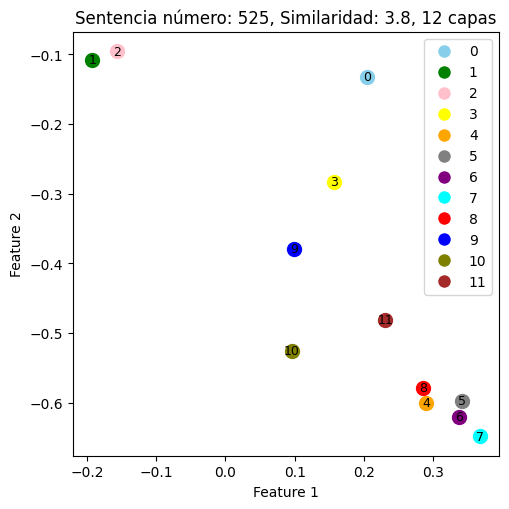

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 525)

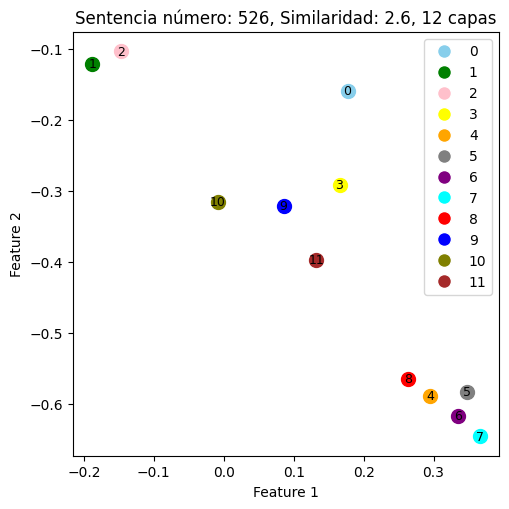

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 526)

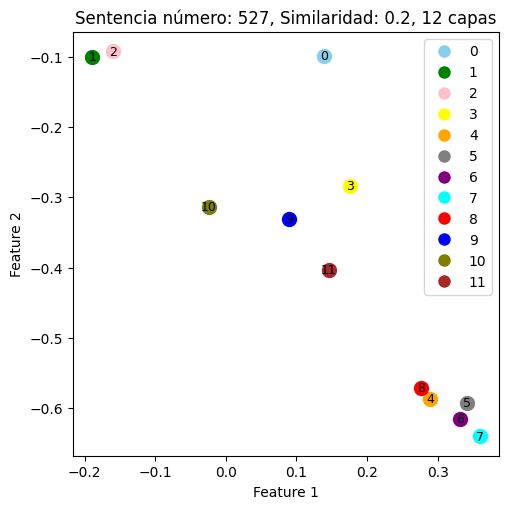

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 527)

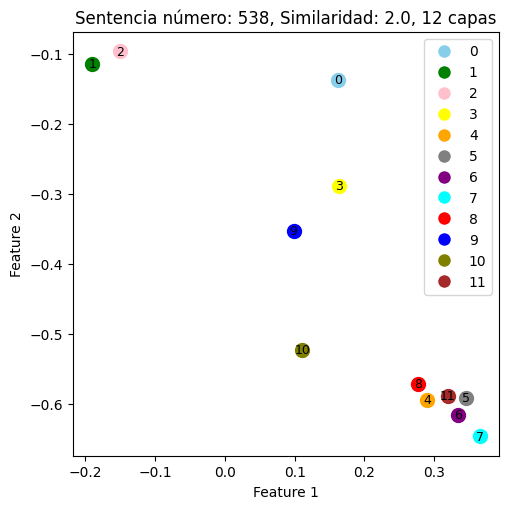

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 538)

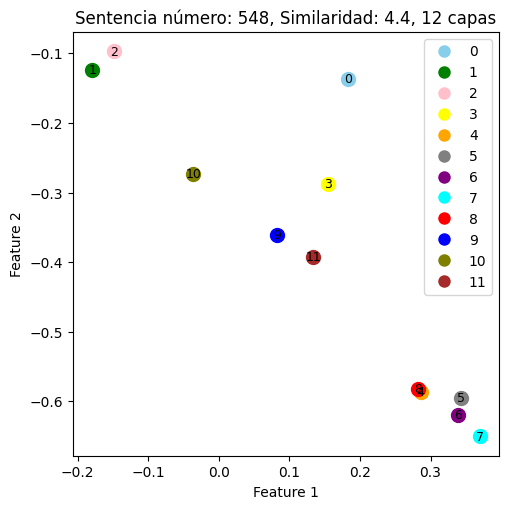

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 548) #lo clasifico como 3.1

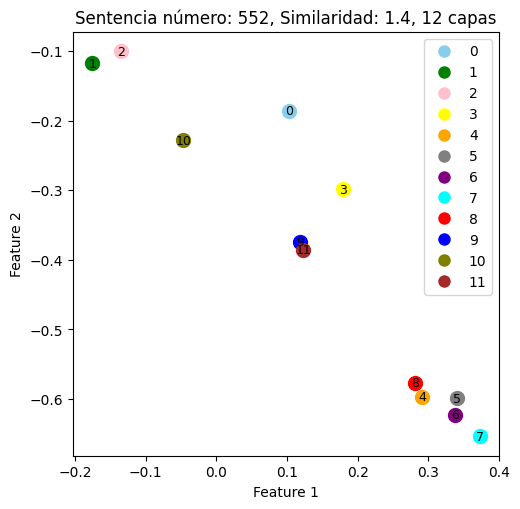

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 552)

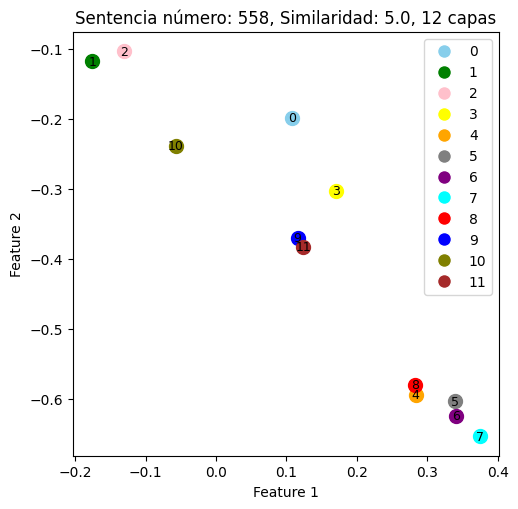

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 558)

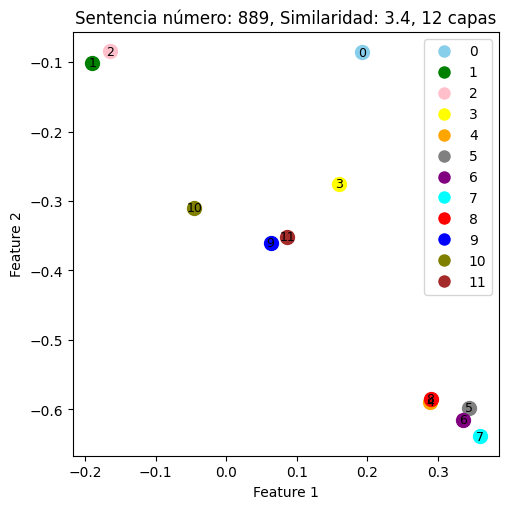

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 889)

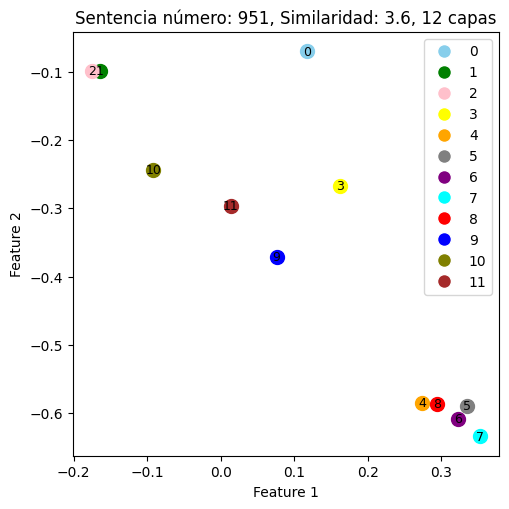

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 951)

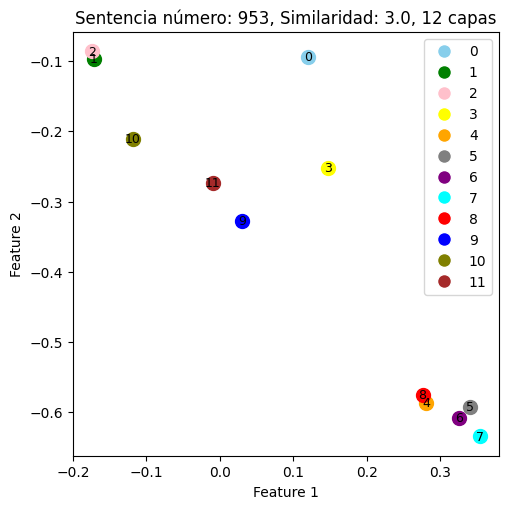

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 953)

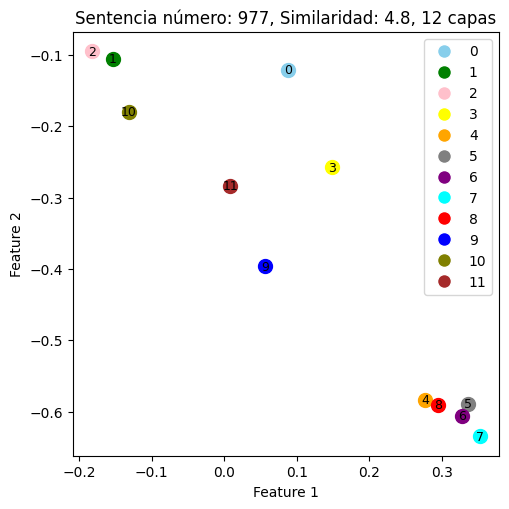

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 977) #lo detecto como 3.8

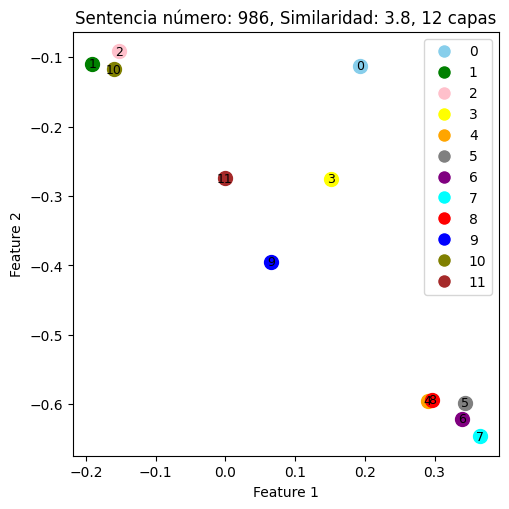

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 986)

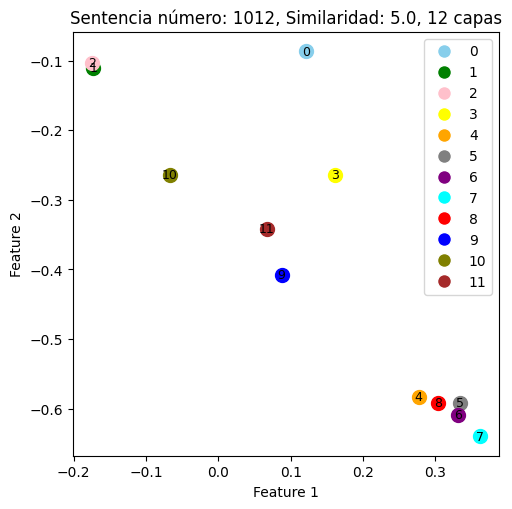

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1012)

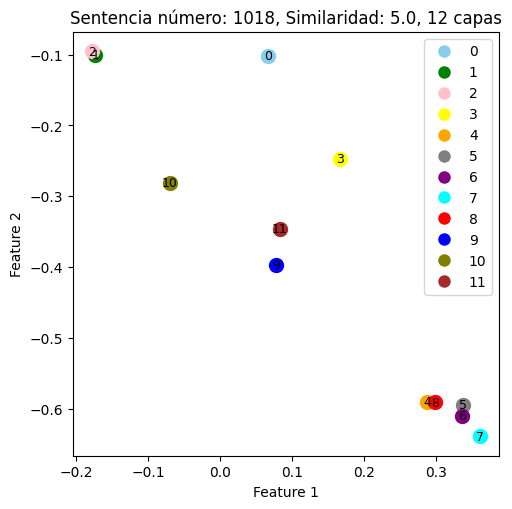

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1018)

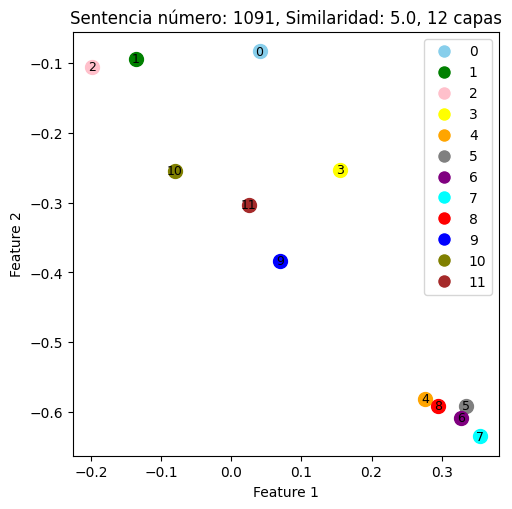

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1091)

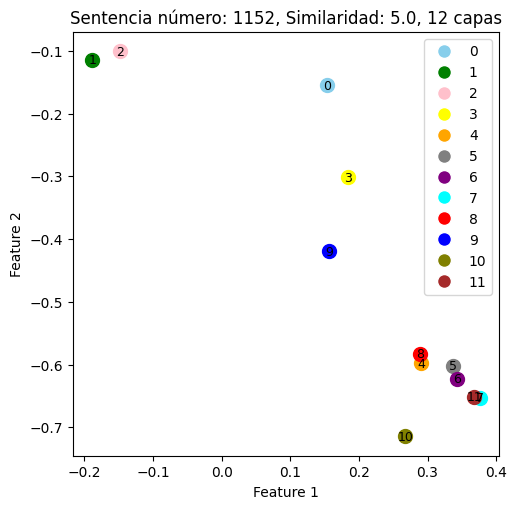

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1151)

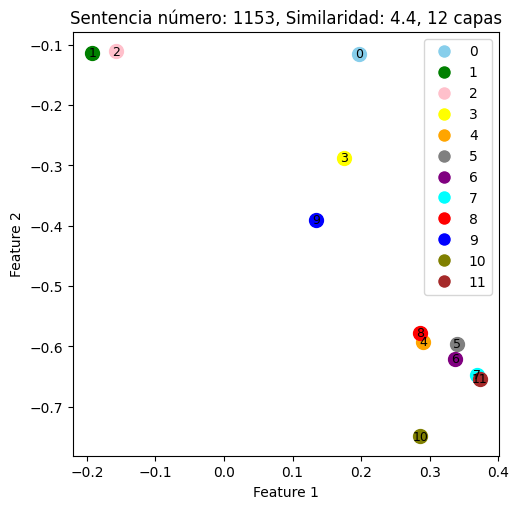

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1153)

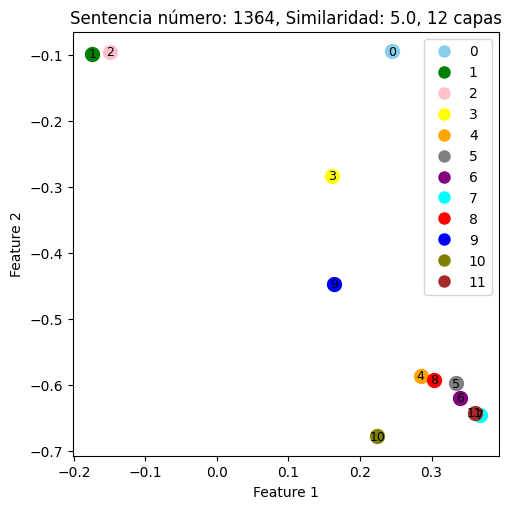

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1364)

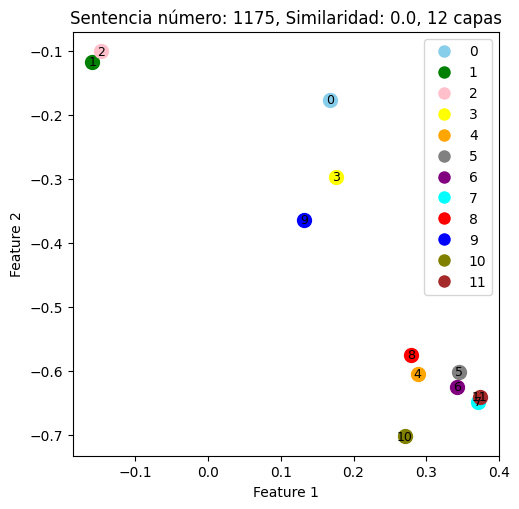

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1175)

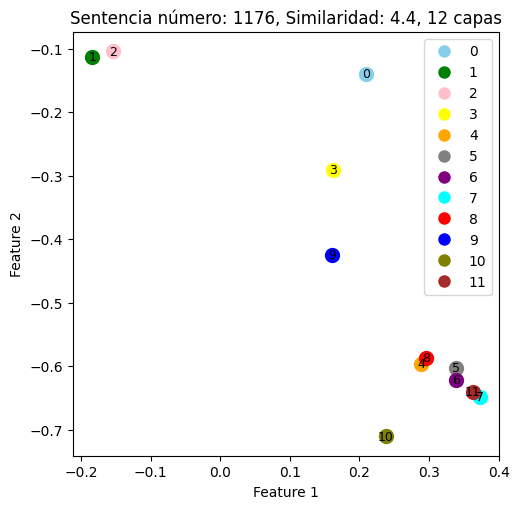

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1176)

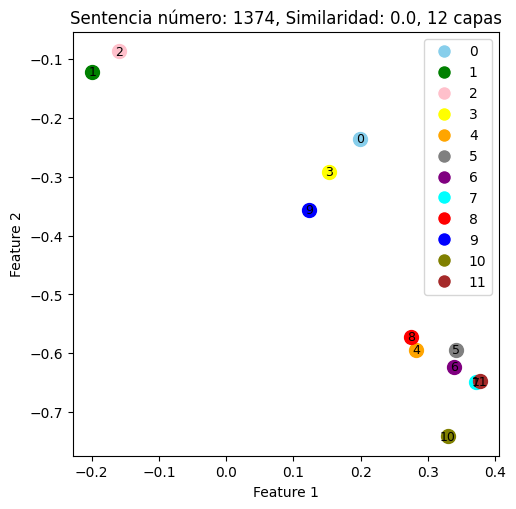

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1374)

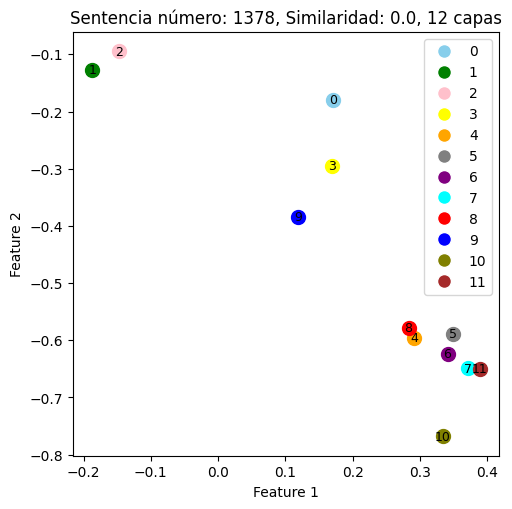

In [ ]:
plot_all_layers_OneSent(vectors_per_layer, 1378)

In [ ]:
for i, v in enumerate(labels_list):
  if v > 4.9:
    print(i)

2
11
38
60
87
125
128
133
136
139
140
158
160
269
275
330
341
364
411
427
431
489
497
499
545
558
566
576
610
623
631
636
645
656
664
668
671
673
674
692
710
719
720
724
727
737
740
745
755
756
757
765
773
775
782
783
788
805
808
810
818
823
829
836
839
844
845
852
853
854
861
862
870
875
877
878
1012
1018
1039
1091
1152
1206
1214
1290
1311
1317
1320
1324
1326
1329
1348
1350
1351
1352
1353
1357
1364
